Running Model-2: 4500it [00:01, 3256.37it/s]<?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Fitting node Ridge-2...


Running Model-2: 470it [00:00, 3352.70it/s]           


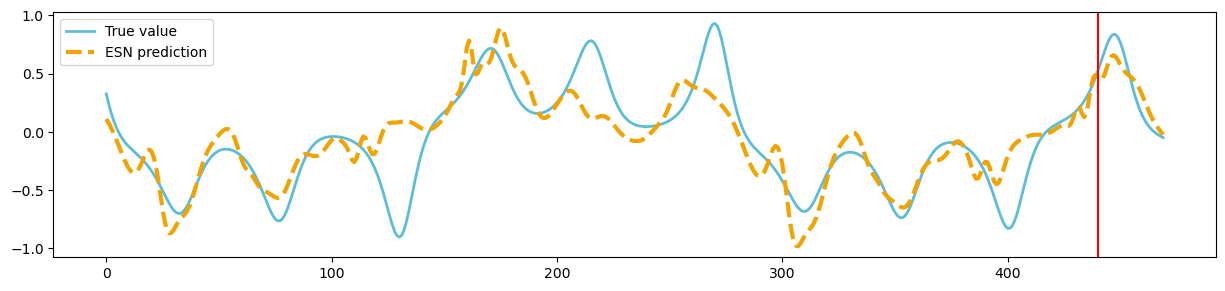

In [8]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import math
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

length = 5000
train = 4500
forecast = 30

###ПОДГОТОВКА ДАННЫХ
#9
import warnings
from nolitsa import data

dt = 0.01
x0 = [0.1, -0.1, 1.0]

#000
x1 = data.lorenz(length=6500, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
import copy
time = copy.deepcopy(x1) 
X1 = time[:,0] 
X1 = X1.reshape(6500,1) 
X1 = 2 * (X1 - X1.min()) / (X1.max() - X1.min()) - 1 
#000
    
X = X1[:5000]


def results(y_pred, y_test):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")

    ax.plot(np.arange(len(y_test)), y_test, lw=2, label="True value", color="#5cbdd9")
    ax.plot(np.arange(len(y_pred)), y_pred, lw=3, label="ESN prediction", color="#f1a300", linestyle="--")
    ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=forecast)

X_train1, y_train1 = x[:train], y[:train]
X_test1, y_test1 = x[train:], y[train:]

#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3 #коэффициент утечки от 0 до 1
spectral_radius = 1.25 #от 0.1 до 1
input_scaling = 1.0
connectivity = 1.0 #от 0 до 1
input_connectivity = 0.2 #тоже %
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
###HERE1

In [9]:
def rmse(x_test, x_sim):
        res = 0
        for i in range(len(x_sim)):
            res = res + (x_sim[i] - x_test[i])**2
        res = math.sqrt(res/len(x_sim))
        return res

rmse(y_pred1[-100:], X[-100:])

C:\Users\nicks\AppData\Local\Temp\ipykernel_1424\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


0.21975051801818915

In [10]:
BestRmse = 0.02967355170437901
BestHyp = np.empty((8, 1))

BestHyp[0] = 100
BestHyp[1] = 0.3
BestHyp[2] = 1.25
BestHyp[3] = 1.0
BestHyp[4] = 1.0
BestHyp[5] = 0.2
BestHyp[6] = 1e-8
BestHyp[7] = 1234

In [11]:
Seed = np.arange(1234, 2034, 300)
Regularization = np.arange(1e-8, 1.0, 0.5)
Input_connectivity = np.arange(0.01, 1.0, 0.5)
Connectivity = np.arange(0.01, 1.0, 0.5)
Input_scaling = np.arange(1.0, 5.0, 2.0)
Spectral_radius = np.arange(0.1, 1.0, 0.5)
Leak_rate = np.arange(0.05, 1.0, 0.5)
Units = np.arange(30, 1000, 400)

In [12]:
for q in range(len(Units)):
    for w in range(len(Leak_rate)):
        for e in range(len(Spectral_radius)):
            for r in range(len(Input_scaling)):
                for t in range(len(Connectivity)):
                    for z in range(len(Input_connectivity)):
                        for u in range(len(Regularization)):
                            for a in range(len(Seed)):
                                #Первый тестовый набор параметров 
                                units = Units[q]
                                leak_rate = Leak_rate[w] #коэффициент утечки от 0 до 1
                                spectral_radius = Spectral_radius[e] #от 0.1 до 1
                                input_scaling = Input_scaling[r]
                                connectivity = Connectivity[t] #от 0 до 1
                                input_connectivity = Input_connectivity[z] #тоже %
                                regularization = Regularization[u]
                                seed = Seed[a]

                                #узел резервуара
                                reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                                    lr=leak_rate, rc_connectivity=connectivity,
                                                    input_connectivity=input_connectivity, seed=seed)
                                #выходной слой(считывающее устройство)
                                readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
                                #соединяем узлы и таким образом получаем модель 
                                esn = reservoir >> readout

                                #обучение модели
                                esn = esn.fit(X_train1, y_train1)
                                #делаем предсказание
                                y_pred1 = esn.run(X_test1, reset=False)
                                #results(y_pred1, X[train+forecast:])
                                Rmse = rmse(y_pred1[-100:], X[-100:])
                                if (Rmse<BestRmse):
                                    BestRmse = Rmse
                                    BestHyp[0] = Units[q]
                                    BestHyp[1] = Leak_rate[w]
                                    BestHyp[2] = Spectral_radius[e]
                                    BestHyp[3] = Input_scaling[r]
                                    BestHyp[4] = Connectivity[t]
                                    BestHyp[5] = Input_connectivity[z]
                                    BestHyp[6] = Regularization[u]
                                    BestHyp[7] = Seed[a]


Running Model-3: 4500it [00:00, 7304.90it/s]<?, ?it/s]
Running Model-3: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-3...


Running Model-3: 470it [00:00, 8103.47it/s]           
C:\Users\nicks\AppData\Local\Temp\ipykernel_1424\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))
Running Model-4: 4500it [00:00, 7692.30it/s]<?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-4...


Running Model-4: 470it [00:00, 8707.83it/s]           
Running Model-5: 4500it [00:00, 6828.32it/s]<?, ?it/s]
Running Model-5: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-5...


Running Model-5: 470it [00:00, 5053.78it/s]           
Running Model-6: 4500it [00:00, 6382.99it/s]<?, ?it/s]
Running Model-6: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-6...


Running Model-6: 470it [00:00, 6620.02it/s]           
Running Model-7: 4500it [00:00, 6880.50it/s]<?, ?it/s]
Running Model-7: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-7...


Running Model-7: 470it [00:00, 7830.32it/s]           
Running Model-8: 4500it [00:00, 6627.39it/s]<?, ?it/s]
Running Model-8: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-8...


Running Model-8: 470it [00:00, 6811.31it/s]           
Running Model-9: 4500it [00:00, 6870.44it/s]<?, ?it/s]
Running Model-9: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-9...


Running Model-9: 470it [00:00, 7832.47it/s]           
Running Model-10: 4500it [00:00, 6716.44it/s]<?, ?it/s]
Running Model-10: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-10...


Running Model-10: 470it [00:00, 7343.93it/s]           
Running Model-11: 4500it [00:00, 7908.21it/s]<?, ?it/s]
Running Model-11: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-11...


Running Model-11: 470it [00:00, 8248.59it/s]           
Running Model-12: 4500it [00:00, 7950.53it/s]<?, ?it/s]
Running Model-12: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-12...


Running Model-12: 470it [00:00, 7119.05it/s]           
Running Model-13: 4500it [00:00, 7538.06it/s]<?, ?it/s]
Running Model-13: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-13...


Running Model-13: 470it [00:00, 8541.63it/s]           
Running Model-14: 4500it [00:00, 7666.10it/s]<?, ?it/s]
Running Model-14: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-14...


Running Model-14: 470it [00:00, 7343.79it/s]           
Running Model-15: 4500it [00:00, 6150.30it/s]<?, ?it/s]
Running Model-15: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-15...


Running Model-15: 470it [00:00, 6619.64it/s]           
Running Model-16: 4500it [00:00, 6164.36it/s]<?, ?it/s]
Running Model-16: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-16...


Running Model-16: 470it [00:00, 6103.56it/s]           
Running Model-17: 4500it [00:00, 6607.92it/s]<?, ?it/s]
Running Model-17: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-17...


Running Model-17: 470it [00:00, 6619.91it/s]           
Running Model-18: 4500it [00:00, 7328.70it/s]<?, ?it/s]
Running Model-18: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-18...


Running Model-18: 470it [00:00, 6266.12it/s]           
Running Model-19: 4500it [00:00, 6976.74it/s]<?, ?it/s]
Running Model-19: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-19...


Running Model-19: 470it [00:00, 6103.26it/s]           
Running Model-20: 4500it [00:00, 6828.54it/s]<?, ?it/s]
Running Model-20: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-20...


Running Model-20: 470it [00:00, 7833.25it/s]           
Running Model-21: 4500it [00:00, 6838.66it/s]<?, ?it/s]
Running Model-21: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-21...


Running Model-21: 470it [00:00, 5662.67it/s]           
Running Model-22: 4500it [00:00, 6933.74it/s]<?, ?it/s]
Running Model-22: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-22...


Running Model-22: 470it [00:00, 6184.23it/s]           
Running Model-23: 4500it [00:00, 7165.38it/s]<?, ?it/s]
Running Model-23: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-23...


Running Model-23: 470it [00:00, 7460.24it/s]           
Running Model-24: 4500it [00:00, 7462.34it/s]<?, ?it/s]
Running Model-24: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-24...


Running Model-24: 470it [00:00, 6266.62it/s]           
Running Model-25: 4500it [00:00, 7353.30it/s]<?, ?it/s]
Running Model-25: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-25...


Running Model-25: 470it [00:00, 4895.30it/s]           
Running Model-26: 4500it [00:00, 7009.38it/s]<?, ?it/s]
Running Model-26: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-26...


Running Model-26: 470it [00:00, 6713.58it/s]           
Running Model-27: 4500it [00:00, 7234.64it/s]<?, ?it/s]
Running Model-27: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-27...


Running Model-27: 470it [00:00, 6350.91it/s]           
Running Model-28: 4500it [00:00, 6766.63it/s]<?, ?it/s]
Running Model-28: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-28...


Running Model-28: 470it [00:00, 7231.05it/s]           
Running Model-29: 4500it [00:00, 7297.88it/s]<?, ?it/s]
Running Model-29: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-29...


Running Model-29: 470it [00:00, 6714.75it/s]           
Running Model-30: 4500it [00:00, 7537.30it/s]<?, ?it/s]
Running Model-30: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-30...


Running Model-30: 470it [00:00, 7343.16it/s]           
Running Model-31: 4500it [00:00, 7936.28it/s]<?, ?it/s]
Running Model-31: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-31...


Running Model-31: 470it [00:00, 6714.31it/s]           
Running Model-32: 4500it [00:00, 7329.33it/s]<?, ?it/s]
Running Model-32: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-32...


Running Model-32: 470it [00:00, 6714.31it/s]           
Running Model-33: 4500it [00:00, 7413.78it/s]<?, ?it/s]
Running Model-33: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-33...


Running Model-33: 470it [00:00, 7832.28it/s]           
Running Model-34: 4500it [00:00, 7311.06it/s]<?, ?it/s]
Running Model-34: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-34...


Running Model-34: 470it [00:00, 6182.45it/s]           
Running Model-35: 4500it [00:00, 7922.96it/s]<?, ?it/s]
Running Model-35: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-35...


Running Model-35: 470it [00:00, 6811.24it/s]           
Running Model-36: 4500it [00:00, 8122.35it/s]<?, ?it/s]
Running Model-36: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-36...


Running Model-36: 470it [00:00, 6619.71it/s]           
Running Model-37: 4500it [00:00, 8021.40it/s]<?, ?it/s]
Running Model-37: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-37...


Running Model-37: 470it [00:00, 8394.29it/s]           
Running Model-38: 4500it [00:00, 7550.33it/s]<?, ?it/s]
Running Model-38: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-38...


Running Model-38: 470it [00:00, 8242.14it/s]           
Running Model-39: 4500it [00:00, 8050.09it/s]<?, ?it/s]
Running Model-39: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-39...


Running Model-39: 470it [00:00, 6911.78it/s]           
Running Model-40: 4500it [00:00, 7364.73it/s]<?, ?it/s]
Running Model-40: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-40...


Running Model-40: 470it [00:00, 7118.85it/s]           
Running Model-41: 4500it [00:00, 7890.15it/s]<?, ?it/s]
Running Model-41: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-41...


Running Model-41: 470it [00:00, 6714.27it/s]           
Running Model-42: 4500it [00:00, 7780.13it/s]<?, ?it/s]
Running Model-42: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Fitting node Ridge-42...


Running Model-42: 470it [00:00, 7120.88it/s]           
Running Model-43: 4500it [00:00, 7246.38it/s]<?, ?it/s]
Running Model-43: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-43...


Running Model-43: 470it [00:00, 7958.19it/s]           
Running Model-44: 4500it [00:00, 8050.09it/s]<?, ?it/s]
Running Model-44: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-44...


Running Model-44: 470it [00:00, 7014.91it/s]           
Running Model-45: 4500it [00:00, 7908.62it/s]<?, ?it/s]
Running Model-45: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-45...


Running Model-45: 470it [00:00, 7014.96it/s]           
Running Model-46: 4500it [00:00, 7413.51it/s]<?, ?it/s]
Running Model-46: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-46...


Running Model-46: 470it [00:00, 6438.36it/s]           
Running Model-47: 4500it [00:00, 7258.07it/s]<?, ?it/s]
Running Model-47: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-47...


Running Model-47: 470it [00:00, 6716.99it/s]           
Running Model-48: 4500it [00:00, 6777.07it/s]<?, ?it/s]
Running Model-48: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-48...


Running Model-48: 470it [00:00, 6103.02it/s]           
Running Model-49: 4500it [00:00, 6746.65it/s]<?, ?it/s]
Running Model-49: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-49...


Running Model-49: 470it [00:00, 7832.16it/s]           
Running Model-50: 4500it [00:00, 7758.32it/s]<?, ?it/s]
Running Model-50: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Fitting node Ridge-50...


Running Model-50: 470it [00:00, 8545.70it/s]           
Running Model-51: 4500it [00:00, 7561.26it/s]<?, ?it/s]
Running Model-51: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-51...


Running Model-51: 470it [00:00, 7347.18it/s]           
Running Model-52: 4500it [00:00, 6746.37it/s]<?, ?it/s]
Running Model-52: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-52...


Running Model-52: 470it [00:00, 7121.01it/s]           
Running Model-53: 4500it [00:00, 7269.54it/s]<?, ?it/s]
Running Model-53: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-53...


Running Model-53: 470it [00:00, 6911.76it/s]           
Running Model-54: 4500it [00:00, 7839.72it/s]<?, ?it/s]
Running Model-54: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-54...


Running Model-54: 470it [00:00, 6527.80it/s]           
Running Model-55: 4500it [00:00, 7575.76it/s]<?, ?it/s]
Running Model-55: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-55...


Running Model-55: 470it [00:00, 6811.90it/s]           
Running Model-56: 4500it [00:00, 7950.17it/s]<?, ?it/s]
Running Model-56: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-56...


Running Model-56: 470it [00:00, 6351.34it/s]           
Running Model-57: 4500it [00:00, 7475.08it/s]<?, ?it/s]
Running Model-57: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-57...


Running Model-57: 470it [00:00, 7461.08it/s]           
Running Model-58: 4500it [00:00, 7352.64it/s]<?, ?it/s]
Running Model-58: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-58...


Running Model-58: 470it [00:00, 6714.27it/s]           
Running Model-59: 4500it [00:00, 7853.40it/s]<?, ?it/s]
Running Model-59: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-59...


Running Model-59: 470it [00:00, 5662.67it/s]           
Running Model-60: 4500it [00:00, 7745.53it/s]<?, ?it/s]
Running Model-60: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-60...


Running Model-60: 470it [00:00, 6811.62it/s]           
Running Model-61: 4500it [00:00, 8108.11it/s]<?, ?it/s]
Running Model-61: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Fitting node Ridge-61...


Running Model-61: 470it [00:00, 6527.80it/s]           
Running Model-62: 4500it [00:00, 7758.63it/s]<?, ?it/s]
Running Model-62: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-62...


Running Model-62: 470it [00:00, 6351.34it/s]           
Running Model-63: 4500it [00:00, 6880.74it/s]<?, ?it/s]
Running Model-63: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-63...


Running Model-63: 470it [00:00, 7121.16it/s]           
Running Model-64: 4500it [00:00, 7438.27it/s]<?, ?it/s]
Running Model-64: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-64...


Running Model-64: 470it [00:00, 6024.09it/s]           
Running Model-65: 4500it [00:00, 7880.91it/s]<?, ?it/s]
Running Model-65: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-65...


Running Model-65: 470it [00:00, 8392.07it/s]           
Running Model-66: 4500it [00:00, 7866.76it/s]<?, ?it/s]
Running Model-66: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-66...


Running Model-66: 470it [00:00, 7965.81it/s]           
Running Model-67: 4500it [00:00, 7771.68it/s]<?, ?it/s]
Running Model-67: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Fitting node Ridge-67...


Running Model-67: 470it [00:00, 6351.32it/s]           
Running Model-68: 4500it [00:00, 7169.67it/s]<?, ?it/s]
Running Model-68: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-68...


Running Model-68: 470it [00:00, 5465.24it/s]           
Running Model-69: 4500it [00:00, 6656.83it/s]<?, ?it/s]
Running Model-69: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-69...


Running Model-69: 470it [00:00, 7460.41it/s]           
Running Model-70: 4500it [00:00, 7462.68it/s]<?, ?it/s]
Running Model-70: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-70...


Running Model-70: 470it [00:00, 6912.31it/s]           
Running Model-71: 4500it [00:00, 6578.70it/s]<?, ?it/s]
Running Model-71: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-71...


Running Model-71: 470it [00:00, 5664.44it/s]           
Running Model-72: 4500it [00:00, 7314.53it/s]<?, ?it/s]
Running Model-72: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-72...


Running Model-72: 470it [00:00, 7345.95it/s]           
Running Model-73: 4500it [00:00, 7340.61it/s]<?, ?it/s]
Running Model-73: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-73...


Running Model-73: 470it [00:00, 6186.70it/s]           
Running Model-74: 4500it [00:00, 6901.58it/s]<?, ?it/s]
Running Model-74: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-74...


Running Model-74: 470it [00:00, 6911.78it/s]           
Running Model-75: 4500it [00:00, 7031.25it/s]<?, ?it/s]
Running Model-75: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-75...


Running Model-75: 470it [00:00, 6103.90it/s]           
Running Model-76: 4500it [00:00, 7853.40it/s]<?, ?it/s]
Running Model-76: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-76...


Running Model-76: 470it [00:00, 7230.79it/s]           
Running Model-77: 4500it [00:00, 7500.00it/s]<?, ?it/s]
Running Model-77: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-77...


Running Model-77: 470it [00:00, 7704.03it/s]           
Running Model-78: 4500it [00:00, 7652.78it/s]<?, ?it/s]
Running Model-78: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-78...


Running Model-78: 470it [00:00, 6527.80it/s]           
Running Model-79: 4500it [00:00, 7812.50it/s]<?, ?it/s]
Running Model-79: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-79...


Running Model-79: 470it [00:00, 6184.17it/s]           
Running Model-80: 4500it [00:00, 7964.21it/s]<?, ?it/s]
Running Model-80: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-80...


Running Model-80: 470it [00:00, 8705.14it/s]           
Running Model-81: 4500it [00:00, 8035.32it/s]<?, ?it/s]
Running Model-81: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-81...


Running Model-81: 470it [00:00, 7017.06it/s]           
Running Model-82: 4500it [00:00, 7613.90it/s]<?, ?it/s]
Running Model-82: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-82...


Running Model-82: 470it [00:00, 6811.57it/s]           
Running Model-83: 4500it [00:00, 7652.97it/s]<?, ?it/s]
Running Model-83: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-83...


Running Model-83: 470it [00:00, 6811.99it/s]           
Running Model-84: 4500it [00:00, 7666.09it/s]<?, ?it/s]
Running Model-84: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-84...


Running Model-84: 470it [00:00, 7460.24it/s]           
Running Model-85: 4500it [00:00, 8064.28it/s]<?, ?it/s]
Running Model-85: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-85...


Running Model-85: 470it [00:00, 8544.89it/s]           
Running Model-86: 4500it [00:00, 7867.16it/s]<?, ?it/s]
Running Model-86: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-86...


Running Model-86: 470it [00:00, 7459.93it/s]           
Running Model-87: 4500it [00:00, 7601.41it/s]<?, ?it/s]
Running Model-87: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-87...


Running Model-87: 470it [00:00, 6185.09it/s]           
Running Model-88: 4500it [00:00, 7692.31it/s]<?, ?it/s]
Running Model-88: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-88...


Running Model-88: 470it [00:00, 6912.82it/s]           
Running Model-89: 4500it [00:00, 7614.17it/s]<?, ?it/s]
Running Model-89: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-89...


Running Model-89: 470it [00:00, 6352.10it/s]           
Running Model-90: 4500it [00:00, 6512.32it/s]<?, ?it/s]
Running Model-90: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-90...


Running Model-90: 470it [00:00, 5222.17it/s]           
Running Model-91: 4500it [00:00, 7223.15it/s]<?, ?it/s]
Running Model-91: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-91...


Running Model-91: 470it [00:00, 5802.75it/s]           
Running Model-92: 4500it [00:00, 6766.88it/s]<?, ?it/s]
Running Model-92: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-92...


Running Model-92: 470it [00:00, 5803.01it/s]           
Running Model-93: 4500it [00:00, 7269.82it/s]<?, ?it/s]
Running Model-93: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-93...


Running Model-93: 470it [00:00, 6714.93it/s]           
Running Model-94: 4500it [00:00, 7407.10it/s]<?, ?it/s]
Running Model-94: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-94...


Running Model-94: 470it [00:00, 7120.62it/s]           
Running Model-95: 4500it [00:00, 7108.98it/s]<?, ?it/s]
Running Model-95: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-95...


Running Model-95: 470it [00:00, 7344.50it/s]           
Running Model-96: 4500it [00:00, 7964.50it/s]<?, ?it/s]
Running Model-96: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-96...


Running Model-96: 470it [00:00, 6025.91it/s]           
Running Model-97: 4500it [00:00, 7964.53it/s]<?, ?it/s]
Running Model-97: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-97...


Running Model-97: 470it [00:00, 5108.89it/s]           
Running Model-98: 4500it [00:00, 7475.12it/s]<?, ?it/s]
Running Model-98: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-98...


Running Model-98: 470it [00:00, 6714.82it/s]           
Running Model-99: 4500it [00:00, 7853.52it/s]<?, ?it/s]
Running Model-99: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-99...


Running Model-99: 470it [00:00, 6025.88it/s]           
Running Model-100: 4500it [00:00, 7647.76it/s]<?, ?it/s]
Running Model-100: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-100...


Running Model-100: 470it [00:00, 8102.87it/s]           
Running Model-101: 4500it [00:00, 8021.32it/s]<?, ?it/s]
Running Model-101: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-101...


Running Model-101: 470it [00:00, 7013.29it/s]           
Running Model-102: 4500it [00:00, 7500.03it/s]<?, ?it/s]
Running Model-102: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-102...


Running Model-102: 470it [00:00, 7119.62it/s]           
Running Model-103: 4500it [00:00, 7142.92it/s]<?, ?it/s]
Running Model-103: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-103...


Running Model-103: 470it [00:00, 5053.66it/s]           
Running Model-104: 4500it [00:00, 7785.51it/s]<?, ?it/s]
Running Model-104: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Fitting node Ridge-104...


Running Model-104: 470it [00:00, 5875.55it/s]           
Running Model-105: 4500it [00:00, 7964.72it/s]<?, ?it/s]
Running Model-105: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-105...


Running Model-105: 470it [00:00, 7461.20it/s]           
Running Model-106: 4500it [00:00, 8050.18it/s]<?, ?it/s]
Running Model-106: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-106...


Running Model-106: 470it [00:00, 7015.03it/s]           
Running Model-107: 4500it [00:00, 7701.26it/s]<?, ?it/s]
Running Model-107: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-107...


Running Model-107: 470it [00:00, 7344.04it/s]           
Running Model-108: 4500it [00:00, 7329.04it/s]<?, ?it/s]
Running Model-108: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-108...


Running Model-108: 470it [00:00, 6811.31it/s]           
Running Model-109: 4500it [00:00, 7936.35it/s]<?, ?it/s]
Running Model-109: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-109...


Running Model-109: 470it [00:00, 6911.51it/s]           
Running Model-110: 4500it [00:00, 7692.06it/s]<?, ?it/s]
Running Model-110: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-110...


Running Model-110: 470it [00:00, 6351.63it/s]           
Running Model-111: 4500it [00:00, 7588.45it/s]<?, ?it/s]
Running Model-111: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-111...


Running Model-111: 470it [00:00, 5529.42it/s]           
Running Model-112: 4500it [00:00, 6686.54it/s]<?, ?it/s]
Running Model-112: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-112...


Running Model-112: 470it [00:00, 4122.47it/s]           
Running Model-113: 4500it [00:00, 6965.96it/s]<?, ?it/s]
Running Model-113: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-113...


Running Model-113: 470it [00:00, 3916.58it/s]           
Running Model-114: 4500it [00:00, 6901.85it/s]<?, ?it/s]
Running Model-114: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-114...


Running Model-114: 470it [00:00, 6351.32it/s]           
Running Model-115: 4500it [00:00, 7120.33it/s]<?, ?it/s]
Running Model-115: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-115...


Running Model-115: 470it [00:00, 7122.01it/s]           
Running Model-116: 4500it [00:00, 6766.79it/s]<?, ?it/s]
Running Model-116: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-116...


Running Model-116: 470it [00:00, 6811.08it/s]           
Running Model-117: 4500it [00:00, 7880.95it/s]<?, ?it/s]
Running Model-117: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-117...


Running Model-117: 470it [00:00, 7121.11it/s]           
Running Model-118: 4500it [00:00, 7525.09it/s]<?, ?it/s]
Running Model-118: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-118...


Running Model-118: 470it [00:00, 6104.13it/s]           
Running Model-119: 4500it [00:00, 7450.24it/s]<?, ?it/s]
Running Model-119: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-119...


Running Model-119: 470it [00:00, 8245.52it/s]           
Running Model-120: 4500it [00:00, 6976.70it/s]<?, ?it/s]
Running Model-120: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-120...


Running Model-120: 470it [00:00, 7228.40it/s]           
Running Model-121: 4500it [00:00, 7705.52it/s]<?, ?it/s]
Running Model-121: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-121...


Running Model-121: 470it [00:00, 6809.78it/s]           
Running Model-122: 4500it [00:00, 7316.95it/s]<?, ?it/s]
Running Model-122: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-122...


Running Model-122: 470it [00:00, 6912.56it/s]           
Running Model-123: 4500it [00:00, 7614.16it/s]<?, ?it/s]
Running Model-123: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-123...


Running Model-123: 470it [00:00, 7015.21it/s]           
Running Model-124: 4500it [00:00, 7731.99it/s]<?, ?it/s]
Running Model-124: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-124...


Running Model-124: 470it [00:00, 6351.01it/s]           
Running Model-125: 4500it [00:00, 7154.40it/s]<?, ?it/s]
Running Model-125: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-125...


Running Model-125: 470it [00:00, 6527.39it/s]           
Running Model-126: 4500it [00:00, 7550.34it/s]<?, ?it/s]
Running Model-126: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-126...


Running Model-126: 470it [00:00, 6527.65it/s]           
Running Model-127: 4500it [00:00, 7211.97it/s]<?, ?it/s]
Running Model-127: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-127...


Running Model-127: 470it [00:00, 8246.59it/s]           
Running Model-128: 4500it [00:00, 7894.77it/s]<?, ?it/s]
Running Model-128: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-128...


Running Model-128: 470it [00:00, 6911.56it/s]           
Running Model-129: 4500it [00:00, 7732.03it/s]<?, ?it/s]
Running Model-129: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-129...


Running Model-129: 470it [00:00, 4086.69it/s]           
Running Model-130: 4500it [00:00, 7550.38it/s]<?, ?it/s]
Running Model-130: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-130...


Running Model-130: 470it [00:00, 7230.66it/s]           
Running Model-131: 4500it [00:00, 7575.74it/s]<?, ?it/s]
Running Model-131: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-131...


Running Model-131: 470it [00:00, 7832.91it/s]           
Running Model-132: 4500it [00:00, 7340.93it/s]<?, ?it/s]
Running Model-132: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-132...


Running Model-132: 470it [00:00, 7832.22it/s]           
Running Model-133: 4500it [00:00, 7352.95it/s]<?, ?it/s]
Running Model-133: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-133...


Running Model-133: 470it [00:00, 5529.56it/s]           
Running Model-134: 4500it [00:00, 7009.37it/s]<?, ?it/s]
Running Model-134: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-134...


Running Model-134: 470it [00:00, 5731.89it/s]           
Running Model-135: 4500it [00:00, 7075.52it/s]<?, ?it/s]
Running Model-135: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-135...


Running Model-135: 470it [00:00, 6713.72it/s]           
Running Model-136: 4500it [00:00, 7200.56it/s]<?, ?it/s]
Running Model-136: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-136...


Running Model-136: 470it [00:00, 6351.75it/s]           
Running Model-137: 4500it [00:00, 6569.29it/s]<?, ?it/s]
Running Model-137: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-137...


Running Model-137: 470it [00:00, 6912.36it/s]           
Running Model-138: 4500it [00:00, 7627.12it/s]<?, ?it/s]
Running Model-138: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-138...


Running Model-138: 470it [00:00, 7013.84it/s]           
Running Model-139: 4500it [00:00, 7075.45it/s]<?, ?it/s]
Running Model-139: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-139...


Running Model-139: 470it [00:00, 3852.63it/s]           
Running Model-140: 4500it [00:00, 7964.65it/s]<?, ?it/s]
Running Model-140: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-140...


Running Model-140: 470it [00:00, 5053.42it/s]           
Running Model-141: 4500it [00:00, 7305.13it/s]<?, ?it/s]
Running Model-141: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-141...


Running Model-141: 470it [00:00, 6619.89it/s]           
Running Model-142: 4500it [00:00, 7475.02it/s]<?, ?it/s]
Running Model-142: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-142...


Running Model-142: 470it [00:00, 6438.02it/s]           
Running Model-143: 4500it [00:00, 7140.76it/s]<?, ?it/s]
Running Model-143: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-143...


Running Model-143: 470it [00:00, 6527.00it/s]           
Running Model-144: 4500it [00:00, 7629.02it/s]<?, ?it/s]
Running Model-144: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-144...


Running Model-144: 470it [00:00, 7966.90it/s]           
Running Model-145: 4500it [00:00, 7880.85it/s]<?, ?it/s]
Running Model-145: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-145...


Running Model-145: 470it [00:00, 6527.75it/s]           
Running Model-146: 4500it [00:00, 7772.01it/s]<?, ?it/s]
Running Model-146: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Fitting node Ridge-146...


Running Model-146: 470it [00:00, 6438.30it/s]           
Running Model-147: 4500it [00:00, 7438.07it/s]<?, ?it/s]
Running Model-147: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-147...


Running Model-147: 470it [00:00, 6104.11it/s]           
Running Model-148: 4500it [00:00, 7575.84it/s]<?, ?it/s]
Running Model-148: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-148...


Running Model-148: 470it [00:00, 6715.21it/s]           
Running Model-149: 4500it [00:00, 7961.14it/s]<?, ?it/s]
Running Model-149: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-149...


Running Model-149: 470it [00:00, 5594.55it/s]           
Running Model-150: 4500it [00:00, 7772.05it/s]<?, ?it/s]
Running Model-150: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-150...


Running Model-150: 470it [00:00, 5529.67it/s]           
Running Model-151: 4500it [00:00, 8049.84it/s]<?, ?it/s]
Running Model-151: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-151...


Running Model-151: 470it [00:00, 6025.69it/s]           
Running Model-152: 4500it [00:00, 7761.73it/s]<?, ?it/s]
Running Model-152: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-152...


Running Model-152: 470it [00:00, 7344.17it/s]           
Running Model-153: 4500it [00:00, 7525.06it/s]<?, ?it/s]
Running Model-153: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-153...


Running Model-153: 470it [00:00, 5875.50it/s]           
Running Model-154: 4500it [00:00, 6976.76it/s]<?, ?it/s]
Running Model-154: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-154...


Running Model-154: 470it [00:00, 5949.15it/s]           
Running Model-155: 4500it [00:00, 6355.87it/s]<?, ?it/s]
Running Model-155: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-155...


Running Model-155: 470it [00:00, 5875.16it/s]           
Running Model-156: 4500it [00:00, 7053.36it/s]<?, ?it/s]
Running Model-156: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-156...


Running Model-156: 470it [00:00, 5529.47it/s]           
Running Model-157: 4500it [00:00, 6826.95it/s]<?, ?it/s]
Running Model-157: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-157...


Running Model-157: 470it [00:00, 6911.90it/s]           
Running Model-158: 4500it [00:00, 7142.85it/s]<?, ?it/s]
Running Model-158: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-158...


Running Model-158: 470it [00:00, 6527.88it/s]           
Running Model-159: 4500it [00:00, 7978.66it/s]<?, ?it/s]
Running Model-159: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-159...


Running Model-159: 470it [00:00, 8705.60it/s]           
Running Model-160: 4500it [00:00, 7575.68it/s]<?, ?it/s]
Running Model-160: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-160...


Running Model-160: 470it [00:00, 6714.38it/s]           
Running Model-161: 4500it [00:00, 7450.34it/s]<?, ?it/s]
Running Model-161: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-161...


Running Model-161: 470it [00:00, 6266.05it/s]           
Running Model-162: 4500it [00:00, 7614.10it/s]<?, ?it/s]
Running Model-162: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-162...


Running Model-162: 470it [00:00, 5949.56it/s]           
Running Model-163: 4500it [00:00, 7978.74it/s]<?, ?it/s]
Running Model-163: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-163...


Running Model-163: 470it [00:00, 6619.66it/s]           
Running Model-164: 4500it [00:00, 7142.87it/s]<?, ?it/s]
Running Model-164: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-164...


Running Model-164: 470it [00:00, 7704.18it/s]           
Running Model-165: 4500it [00:00, 7771.85it/s]<?, ?it/s]
Running Model-165: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-165...


Running Model-165: 470it [00:00, 6811.36it/s]           
Running Model-166: 4500it [00:00, 7922.34it/s]<?, ?it/s]
Running Model-166: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-166...


Running Model-166: 470it [00:00, 6811.88it/s]           
Running Model-167: 4500it [00:00, 7619.94it/s]<?, ?it/s]
Running Model-167: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-167...


Running Model-167: 470it [00:00, 5948.69it/s]           
Running Model-168: 4500it [00:00, 7588.58it/s]<?, ?it/s]
Running Model-168: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-168...


Running Model-168: 470it [00:00, 6619.84it/s]           
Running Model-169: 4500it [00:00, 7237.49it/s]<?, ?it/s]
Running Model-169: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-169...


Running Model-169: 470it [00:00, 6350.65it/s]           
Running Model-170: 4500it [00:00, 7652.83it/s]<?, ?it/s]
Running Model-170: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-170...


Running Model-170: 470it [00:00, 6351.67it/s]           
Running Model-171: 4500it [00:00, 7524.94it/s]<?, ?it/s]
Running Model-171: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-171...


Running Model-171: 470it [00:00, 4233.86it/s]           
Running Model-172: 4500it [00:00, 8117.64it/s]<?, ?it/s]
Running Model-172: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Fitting node Ridge-172...


Running Model-172: 470it [00:00, 6437.50it/s]           
Running Model-173: 4500it [00:00, 7839.54it/s]<?, ?it/s]
Running Model-173: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-173...


Running Model-173: 470it [00:00, 6350.89it/s]           
Running Model-174: 4500it [00:00, 6901.89it/s]<?, ?it/s]
Running Model-174: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-174...


Running Model-174: 470it [00:00, 5663.40it/s]           
Running Model-175: 4500it [00:00, 6617.70it/s]<?, ?it/s]
Running Model-175: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-175...


Running Model-175: 470it [00:00, 5949.37it/s]           
Running Model-176: 4500it [00:00, 7679.26it/s]<?, ?it/s]
Running Model-176: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-176...


Running Model-176: 470it [00:00, 4747.17it/s]           
Running Model-177: 4500it [00:00, 6891.21it/s]<?, ?it/s]
Running Model-177: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-177...


Running Model-177: 470it [00:00, 6266.32it/s]           
Running Model-178: 4500it [00:00, 7442.15it/s]<?, ?it/s]
Running Model-178: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-178...


Running Model-178: 470it [00:00, 6528.01it/s]           
Running Model-179: 4500it [00:00, 7120.01it/s]<?, ?it/s]
Running Model-179: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-179...


Running Model-179: 470it [00:00, 6438.53it/s]           
Running Model-180: 4500it [00:00, 7097.98it/s]<?, ?it/s]
Running Model-180: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-180...


Running Model-180: 470it [00:00, 6811.55it/s]           
Running Model-181: 4500it [00:00, 7692.29it/s]<?, ?it/s]
Running Model-181: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-181...


Running Model-181: 470it [00:00, 7832.91it/s]           
Running Model-182: 4500it [00:00, 7758.55it/s]<?, ?it/s]
Running Model-182: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-182...


Running Model-182: 470it [00:00, 7015.06it/s]           
Running Model-183: 4500it [00:00, 7601.15it/s]<?, ?it/s]
Running Model-183: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-183...


Running Model-183: 470it [00:00, 6713.79it/s]           
Running Model-184: 4500it [00:00, 7027.81it/s]<?, ?it/s]
Running Model-184: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-184...


Running Model-184: 470it [00:00, 5529.24it/s]           
Running Model-185: 4500it [00:00, 7639.84it/s]<?, ?it/s]
Running Model-185: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-185...


Running Model-185: 470it [00:00, 7965.87it/s]           
Running Model-186: 4500it [00:00, 6828.55it/s]<?, ?it/s]
Running Model-186: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-186...


Running Model-186: 470it [00:00, 7014.36it/s]           
Running Model-187: 4500it [00:00, 7601.31it/s]<?, ?it/s]
Running Model-187: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-187...


Running Model-187: 470it [00:00, 6025.56it/s]           
Running Model-188: 4500it [00:00, 7853.09it/s]<?, ?it/s]
Running Model-188: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-188...


Running Model-188: 470it [00:00, 7343.82it/s]           
Running Model-189: 4500it [00:00, 7825.94it/s]<?, ?it/s]
Running Model-189: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-189...


Running Model-189: 470it [00:00, 7703.88it/s]           
Running Model-190: 4500it [00:00, 7499.82it/s]<?, ?it/s]
Running Model-190: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-190...


Running Model-190: 470it [00:00, 6527.43it/s]           
Running Model-191: 4500it [00:00, 7328.78it/s]<?, ?it/s]
Running Model-191: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-191...


Running Model-191: 470it [00:00, 6811.41it/s]           
Running Model-192: 4500it [00:00, 7031.17it/s]<?, ?it/s]
Running Model-192: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-192...


Running Model-192: 470it [00:00, 5661.53it/s]           
Running Model-193: 4500it [00:00, 6746.52it/s]<?, ?it/s]
Running Model-193: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-193...


Running Model-193: 470it [00:00, 7121.16it/s]           
Running Model-194: 4500it [00:00, 8093.48it/s]<?, ?it/s]
Running Model-194: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Fitting node Ridge-194...


Running Model-194: 470it [00:00, 6912.73it/s]           
Running Model-195: 4500it [00:00, 6807.88it/s]<?, ?it/s]
Running Model-195: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-195...


Running Model-195: 470it [00:00, 5109.25it/s]           
Running Model-196: 4500it [00:00, 6807.99it/s]<?, ?it/s]
Running Model-196: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-196...


Running Model-196: 470it [00:00, 6351.57it/s]           
Running Model-197: 4500it [00:00, 6807.49it/s]<?, ?it/s]
Running Model-197: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-197...


Running Model-197: 470it [00:00, 5948.56it/s]           
Running Model-198: 4500it [00:00, 6933.83it/s]<?, ?it/s]
Running Model-198: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-198...


Running Model-198: 470it [00:00, 7706.86it/s]           
Running Model-199: 4500it [00:00, 6891.31it/s]<?, ?it/s]
Running Model-199: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-199...


Running Model-199: 470it [00:00, 6351.50it/s]           
Running Model-200: 4500it [00:00, 6428.43it/s]<?, ?it/s]
Running Model-200: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-200...


Running Model-200: 470it [00:00, 7966.39it/s]           
Running Model-201: 4500it [00:00, 6787.07it/s]<?, ?it/s]
Running Model-201: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-201...


Running Model-201: 470it [00:00, 5949.26it/s]           
Running Model-202: 4500it [00:00, 6976.73it/s]<?, ?it/s]
Running Model-202: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-202...


Running Model-202: 470it [00:00, 3759.89it/s]           
Running Model-203: 4500it [00:00, 7340.96it/s]<?, ?it/s]
Running Model-203: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-203...


Running Model-203: 470it [00:00, 7015.23it/s]           
Running Model-204: 4500it [00:00, 7086.52it/s]<?, ?it/s]
Running Model-204: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-204...


Running Model-204: 470it [00:00, 7344.64it/s]           
Running Model-205: 4500it [00:00, 6686.46it/s]<?, ?it/s]
Running Model-205: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-205...


Running Model-205: 470it [00:00, 7706.20it/s]           
Running Model-206: 4500it [00:00, 7550.26it/s]<?, ?it/s]
Running Model-206: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-206...


Running Model-206: 470it [00:00, 6909.07it/s]           
Running Model-207: 4500it [00:01, 4385.94it/s]<?, ?it/s]
Running Model-207: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-207...


Running Model-207: 470it [00:00, 4607.60it/s]           
Running Model-208: 4500it [00:00, 4508.97it/s]<?, ?it/s]
Running Model-208: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-208...


Running Model-208: 470it [00:00, 4392.84it/s]           
Running Model-209: 4500it [00:01, 4143.63it/s]<?, ?it/s]
Running Model-209: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Fitting node Ridge-209...


Running Model-209: 470it [00:00, 4433.87it/s]           
Running Model-210: 4500it [00:01, 4403.13it/s]<?, ?it/s]
Running Model-210: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-210...


Running Model-210: 470it [00:00, 4351.04it/s]           
Running Model-211: 4500it [00:01, 4343.11it/s]<?, ?it/s]
Running Model-211: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Fitting node Ridge-211...


Running Model-211: 470it [00:00, 3789.97it/s]           
Running Model-212: 4500it [00:01, 3975.24it/s]<?, ?it/s]
Running Model-212: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-212...


Running Model-212: 470it [00:00, 4795.41it/s]           
Running Model-213: 4500it [00:01, 3887.53it/s]<?, ?it/s]
Running Model-213: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Fitting node Ridge-213...


Running Model-213: 470it [00:00, 3615.49it/s]           
Running Model-214: 4500it [00:01, 4094.62it/s]<?, ?it/s]
Running Model-214: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Fitting node Ridge-214...


Running Model-214: 470it [00:00, 4233.59it/s]           
Running Model-215: 4500it [00:01, 4364.65it/s]<?, ?it/s]
Running Model-215: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-215...


Running Model-215: 470it [00:00, 4159.34it/s]           
Running Model-216: 4500it [00:01, 4174.42it/s]<?, ?it/s]
Running Model-216: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-216...


Running Model-216: 470it [00:00, 3851.74it/s]           
Running Model-217: 4500it [00:00, 4521.87it/s]<?, ?it/s]
Running Model-217: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-217...


Running Model-217: 470it [00:00, 3614.98it/s]           
Running Model-218: 4500it [00:01, 4390.24it/s]<?, ?it/s]
Running Model-218: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-218...


Running Model-218: 470it [00:00, 4653.33it/s]           
Running Model-219: 4500it [00:00, 7268.67it/s]<?, ?it/s]
Running Model-219: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-219...


Running Model-219: 470it [00:00, 7965.68it/s]           
Running Model-220: 4500it [00:00, 7188.42it/s]<?, ?it/s]
Running Model-220: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-220...


Running Model-220: 470it [00:00, 7965.75it/s]           
Running Model-221: 4500it [00:00, 7200.02it/s]<?, ?it/s]
Running Model-221: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-221...


Running Model-221: 470it [00:00, 5949.31it/s]           
Running Model-222: 4500it [00:00, 7176.90it/s]<?, ?it/s]
Running Model-222: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-222...


Running Model-222: 470it [00:00, 7581.11it/s]           
Running Model-223: 4500it [00:00, 7246.26it/s]<?, ?it/s]
Running Model-223: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-223...


Running Model-223: 470it [00:00, 6439.10it/s]           
Running Model-224: 4500it [00:00, 7019.97it/s]<?, ?it/s]
Running Model-224: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-224...


Running Model-224: 470it [00:00, 3852.38it/s]           
Running Model-225: 4500it [00:00, 7154.22it/s]<?, ?it/s]
Running Model-225: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-225...


Running Model-225: 470it [00:00, 7581.66it/s]           
Running Model-226: 4500it [00:00, 6007.96it/s]<?, ?it/s]
Running Model-226: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-226...


Running Model-226: 470it [00:00, 6183.96it/s]           
Running Model-227: 4500it [00:00, 6578.97it/s]<?, ?it/s]
Running Model-227: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-227...


Running Model-227: 470it [00:00, 6266.54it/s]           
Running Model-228: 4500it [00:00, 6016.04it/s]<?, ?it/s]
Running Model-228: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-228...


Running Model-228: 470it [00:00, 6351.71it/s]           
Running Model-229: 4500it [00:00, 6502.37it/s]<?, ?it/s]
Running Model-229: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-229...


Running Model-229: 470it [00:00, 6809.81it/s]           
Running Model-230: 4500it [00:00, 6817.99it/s]<?, ?it/s]
Running Model-230: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-230...


Running Model-230: 470it [00:00, 6438.40it/s]           
Running Model-231: 4500it [00:01, 4206.92it/s]<?, ?it/s]
Running Model-231: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-231...


Running Model-231: 470it [00:00, 4700.40it/s]           
Running Model-232: 4500it [00:00, 4545.43it/s]<?, ?it/s]
Running Model-232: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-232...


Running Model-232: 470it [00:00, 3560.84it/s]           
Running Model-233: 4500it [00:01, 4318.65it/s]<?, ?it/s]
Running Model-233: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fitting node Ridge-233...


Running Model-233: 470it [00:00, 4017.34it/s]           
Running Model-234: 4500it [00:00, 4513.58it/s]<?, ?it/s]
Running Model-234: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-234...


Running Model-234: 470it [00:00, 4519.16it/s]           
Running Model-235: 4500it [00:01, 4281.64it/s]<?, ?it/s]
Running Model-235: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Fitting node Ridge-235...


Running Model-235: 470it [00:00, 3729.97it/s]           
Running Model-236: 4500it [00:00, 4548.71it/s]<?, ?it/s]
Running Model-236: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-236...


Running Model-236: 470it [00:00, 3455.97it/s]           
Running Model-237: 4500it [00:01, 4380.73it/s]<?, ?it/s]
Running Model-237: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-237...


Running Model-237: 470it [00:00, 4234.17it/s]           
Running Model-238: 4500it [00:01, 4445.69it/s]<?, ?it/s]
Running Model-238: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Fitting node Ridge-238...


Running Model-238: 470it [00:00, 4795.50it/s]           
Running Model-239: 4500it [00:01, 4293.89it/s]<?, ?it/s]
Running Model-239: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fitting node Ridge-239...


Running Model-239: 470it [00:00, 4086.86it/s]           
Running Model-240: 4500it [00:01, 3985.82it/s]<?, ?it/s]
Running Model-240: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-240...


Running Model-240: 470it [00:00, 4233.49it/s]           
Running Model-241: 4500it [00:01, 3997.97it/s]<?, ?it/s]
Running Model-241: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-241...


Running Model-241: 470it [00:00, 4434.19it/s]           
Running Model-242: 4500it [00:01, 3906.28it/s]<?, ?it/s]
Running Model-242: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Fitting node Ridge-242...


Running Model-242: 470it [00:00, 4434.02it/s]           
Running Model-243: 4500it [00:00, 6866.66it/s]<?, ?it/s]
Running Model-243: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-243...


Running Model-243: 470it [00:00, 5401.64it/s]           
Running Model-244: 4500it [00:00, 7450.44it/s]<?, ?it/s]
Running Model-244: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-244...


Running Model-244: 470it [00:00, 7579.45it/s]           
Running Model-245: 4500it [00:00, 7413.17it/s]<?, ?it/s]
Running Model-245: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-245...


Running Model-245: 470it [00:00, 6437.54it/s]           
Running Model-246: 4500it [00:00, 7211.57it/s]<?, ?it/s]
Running Model-246: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-246...


Running Model-246: 470it [00:00, 5594.94it/s]           
Running Model-247: 4500it [00:00, 7039.69it/s]<?, ?it/s]
Running Model-247: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-247...


Running Model-247: 470it [00:00, 7344.64it/s]           
Running Model-248: 4500it [00:00, 7269.59it/s]<?, ?it/s]
Running Model-248: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-248...


Running Model-248: 470it [00:00, 4947.42it/s]           
Running Model-249: 4500it [00:00, 6998.34it/s]<?, ?it/s]
Running Model-249: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-249...


Running Model-249: 470it [00:00, 5731.67it/s]           
Running Model-250: 4500it [00:00, 6963.58it/s]<?, ?it/s]
Running Model-250: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-250...


Running Model-250: 470it [00:00, 7120.00it/s]           
Running Model-251: 4500it [00:00, 6941.92it/s]<?, ?it/s]
Running Model-251: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-251...


Running Model-251: 470it [00:00, 6713.10it/s]           
Running Model-252: 4500it [00:00, 7165.47it/s]<?, ?it/s]
Running Model-252: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-252...


Running Model-252: 470it [00:00, 7834.52it/s]           
Running Model-253: 4500it [00:00, 7437.79it/s]<?, ?it/s]
Running Model-253: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-253...


Running Model-253: 470it [00:00, 6352.04it/s]           
Running Model-254: 4500it [00:00, 7376.87it/s]<?, ?it/s]
Running Model-254: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-254...


Running Model-254: 470it [00:00, 7460.32it/s]           
Running Model-255: 4500it [00:00, 4624.73it/s]<?, ?it/s]
Running Model-255: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-255...


Running Model-255: 470it [00:00, 4998.90it/s]           
Running Model-256: 4500it [00:01, 3872.63it/s]<?, ?it/s]
Running Model-256: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-256...


Running Model-256: 470it [00:00, 3730.15it/s]           
Running Model-257: 4500it [00:01, 4007.13it/s]<?, ?it/s]
Running Model-257: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-257...


Running Model-257: 470it [00:00, 4350.78it/s]           
Running Model-258: 4500it [00:00, 4517.08it/s]<?, ?it/s]
Running Model-258: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-258...


Running Model-258: 470it [00:00, 4233.58it/s]           
Running Model-259: 4500it [00:01, 4495.51it/s]<?, ?it/s]
Running Model-259: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Fitting node Ridge-259...


Running Model-259: 470it [00:00, 3072.55it/s]           
Running Model-260: 4500it [00:00, 4657.32it/s]<?, ?it/s]
Running Model-260: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-260...


Running Model-260: 470it [00:00, 4845.49it/s]           
Running Model-261: 4500it [00:00, 4620.10it/s]<?, ?it/s]
Running Model-261: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-261...


Running Model-261: 470it [00:00, 3455.62it/s]           
Running Model-262: 4500it [00:00, 4587.17it/s]<?, ?it/s]
Running Model-262: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-262...


Running Model-262: 470it [00:00, 4895.37it/s]           
Running Model-263: 4500it [00:00, 4577.73it/s]<?, ?it/s]
Running Model-263: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-263...


Running Model-263: 470it [00:00, 3481.43it/s]           
Running Model-264: 4500it [00:00, 4582.41it/s]<?, ?it/s]
Running Model-264: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-264...


Running Model-264: 470it [00:00, 4746.46it/s]           
Running Model-265: 4500it [00:00, 4615.29it/s]<?, ?it/s]
Running Model-265: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-265...


Running Model-265: 470it [00:00, 3263.87it/s]           
Running Model-266: 4500it [00:00, 4568.56it/s]<?, ?it/s]
Running Model-266: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-266...


Running Model-266: 470it [00:00, 4392.39it/s]           
Running Model-267: 4500it [00:00, 7500.03it/s]<?, ?it/s]
Running Model-267: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-267...


Running Model-267: 470it [00:00, 8392.04it/s]           
Running Model-268: 4500it [00:00, 6899.82it/s]<?, ?it/s]
Running Model-268: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-268...


Running Model-268: 470it [00:00, 7581.17it/s]           
Running Model-269: 4500it [00:00, 6540.68it/s]<?, ?it/s]
Running Model-269: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-269...


Running Model-269: 470it [00:00, 7580.15it/s]           
Running Model-270: 4500it [00:00, 6756.83it/s]<?, ?it/s]
Running Model-270: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-270...


Running Model-270: 470it [00:00, 5221.56it/s]           
Running Model-271: 4500it [00:00, 7009.34it/s]<?, ?it/s]
Running Model-271: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-271...


Running Model-271: 470it [00:00, 7460.83it/s]           
Running Model-272: 4500it [00:00, 7319.05it/s]<?, ?it/s]
Running Model-272: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-272...


Running Model-272: 470it [00:00, 8243.59it/s]           
Running Model-273: 4500it [00:00, 6807.87it/s]<?, ?it/s]
Running Model-273: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-273...


Running Model-273: 470it [00:00, 7833.59it/s]           
Running Model-274: 4500it [00:00, 7438.15it/s]<?, ?it/s]
Running Model-274: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-274...


Running Model-274: 470it [00:00, 7704.21it/s]           
Running Model-275: 4500it [00:00, 7154.18it/s]<?, ?it/s]
Running Model-275: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-275...


Running Model-275: 470it [00:00, 7459.45it/s]           
Running Model-276: 4500it [00:00, 6777.10it/s]<?, ?it/s]
Running Model-276: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-276...


Running Model-276: 470it [00:00, 7460.55it/s]           
Running Model-277: 4500it [00:00, 7437.82it/s]<?, ?it/s]
Running Model-277: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-277...


Running Model-277: 470it [00:00, 7461.90it/s]           
Running Model-278: 4500it [00:00, 7376.92it/s]<?, ?it/s]
Running Model-278: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-278...


Running Model-278: 470it [00:00, 7343.93it/s]           
Running Model-279: 4500it [00:00, 4629.03it/s]<?, ?it/s]
Running Model-279: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-279...


Running Model-279: 470it [00:00, 5108.44it/s]           
Running Model-280: 4500it [00:00, 4573.14it/s]<?, ?it/s]
Running Model-280: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-280...


Running Model-280: 470it [00:00, 4845.58it/s]           
Running Model-281: 4500it [00:00, 4591.79it/s]<?, ?it/s]
Running Model-281: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-281...


Running Model-281: 470it [00:00, 4476.90it/s]           
Running Model-282: 4500it [00:00, 4628.82it/s]<?, ?it/s]
Running Model-282: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-282...


Running Model-282: 470it [00:00, 4563.26it/s]           
Running Model-283: 4500it [00:00, 4692.39it/s]<?, ?it/s]
Running Model-283: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-283...


Running Model-283: 470it [00:00, 5053.24it/s]           
Running Model-284: 4500it [00:00, 4568.58it/s]<?, ?it/s]
Running Model-284: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-284...


Running Model-284: 470it [00:00, 3333.15it/s]           
Running Model-285: 4500it [00:01, 3940.47it/s]<?, ?it/s]
Running Model-285: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-285...


Running Model-285: 470it [00:00, 4196.42it/s]           
Running Model-286: 4500it [00:01, 3649.62it/s]<?, ?it/s]
Running Model-286: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Fitting node Ridge-286...


Running Model-286: 470it [00:00, 3949.53it/s]           
Running Model-287: 4500it [00:01, 4322.76it/s]<?, ?it/s]
Running Model-287: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Fitting node Ridge-287...


Running Model-287: 470it [00:00, 4311.42it/s]           
Running Model-288: 4500it [00:01, 4335.28it/s]<?, ?it/s]
Running Model-288: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Fitting node Ridge-288...


Running Model-288: 470it [00:00, 5053.02it/s]           
Running Model-289: 4500it [00:00, 4639.13it/s]<?, ?it/s]
Running Model-289: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-289...


Running Model-289: 470it [00:00, 4653.50it/s]           
Running Model-290: 4500it [00:00, 4559.27it/s]<?, ?it/s]
Running Model-290: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-290...


Running Model-290: 470it [00:00, 4519.11it/s]           
Running Model-291: 4500it [00:00, 7589.43it/s]<?, ?it/s]
Running Model-291: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-291...


Running Model-291: 470it [00:00, 8245.04it/s]           
Running Model-292: 4500it [00:00, 7425.53it/s]<?, ?it/s]
Running Model-292: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-292...


Running Model-292: 470it [00:00, 7015.18it/s]           
Running Model-293: 4500it [00:00, 7401.21it/s]<?, ?it/s]
Running Model-293: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-293...


Running Model-293: 470it [00:00, 7341.71it/s]           
Running Model-294: 4500it [00:00, 7389.09it/s]<?, ?it/s]
Running Model-294: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-294...


Running Model-294: 470it [00:00, 7459.81it/s]           
Running Model-295: 4500it [00:00, 7340.93it/s]<?, ?it/s]
Running Model-295: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-295...


Running Model-295: 470it [00:00, 4699.50it/s]           
Running Model-296: 4500it [00:00, 7450.15it/s]<?, ?it/s]
Running Model-296: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-296...


Running Model-296: 470it [00:00, 7459.11it/s]           
Running Model-297: 4500it [00:00, 7234.76it/s]<?, ?it/s]
Running Model-297: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-297...


Running Model-297: 470it [00:00, 7581.84it/s]           
Running Model-298: 4500it [00:00, 6521.56it/s]<?, ?it/s]
Running Model-298: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-298...


Running Model-298: 470it [00:00, 7966.00it/s]           
Running Model-299: 4500it [00:00, 7537.77it/s]<?, ?it/s]
Running Model-299: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-299...


Running Model-299: 470it [00:00, 7833.78it/s]           
Running Model-300: 4500it [00:00, 7177.00it/s]<?, ?it/s]
Running Model-300: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-300...


Running Model-300: 470it [00:00, 7834.49it/s]           
Running Model-301: 4500it [00:00, 6617.67it/s]<?, ?it/s]
Running Model-301: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-301...


Running Model-301: 470it [00:00, 8104.27it/s]           
Running Model-302: 4500it [00:00, 6901.84it/s]<?, ?it/s]
Running Model-302: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-302...


Running Model-302: 470it [00:00, 7964.17it/s]           
Running Model-303: 4500it [00:01, 3864.21it/s]<?, ?it/s]
Running Model-303: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-303...


Running Model-303: 470it [00:00, 5052.81it/s]           
Running Model-304: 4500it [00:01, 4285.36it/s]<?, ?it/s]
Running Model-304: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Fitting node Ridge-304...


Running Model-304: 470it [00:00, 4476.20it/s]           
Running Model-305: 4500it [00:00, 4531.72it/s]<?, ?it/s]
Running Model-305: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-305...


Running Model-305: 470it [00:00, 4844.95it/s]           
Running Model-306: 4500it [00:00, 4615.38it/s]<?, ?it/s]
Running Model-306: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-306...


Running Model-306: 470it [00:00, 4946.39it/s]           
Running Model-307: 4500it [00:00, 4663.21it/s]<?, ?it/s]
Running Model-307: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-307...


Running Model-307: 470it [00:00, 4844.62it/s]           
Running Model-308: 4500it [00:00, 4605.89it/s]<?, ?it/s]
Running Model-308: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-308...


Running Model-308: 470it [00:00, 5052.73it/s]           
Running Model-309: 4500it [00:00, 4559.19it/s]<?, ?it/s]
Running Model-309: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-309...


Running Model-309: 470it [00:00, 5221.73it/s]           
Running Model-310: 4500it [00:00, 4620.13it/s]<?, ?it/s]
Running Model-310: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-310...


Running Model-310: 470it [00:00, 4476.26it/s]           
Running Model-311: 4500it [00:00, 4596.50it/s]<?, ?it/s]
Running Model-311: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-311...


Running Model-311: 470it [00:00, 5164.64it/s]           
Running Model-312: 4500it [00:00, 4550.04it/s]<?, ?it/s]
Running Model-312: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-312...


Running Model-312: 470it [00:00, 5109.13it/s]           
Running Model-313: 4500it [00:01, 4406.40it/s]<?, ?it/s]
Running Model-313: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Fitting node Ridge-313...


Running Model-313: 470it [00:00, 3760.05it/s]           
Running Model-314: 4500it [00:01, 3889.36it/s]<?, ?it/s]
Running Model-314: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Fitting node Ridge-314...


Running Model-314: 470it [00:00, 4051.70it/s]           
Running Model-315: 4500it [00:00, 6114.20it/s]<?, ?it/s]
Running Model-315: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-315...


Running Model-315: 470it [00:00, 8103.94it/s]           
Running Model-316: 4500it [00:00, 6891.35it/s]<?, ?it/s]
Running Model-316: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-316...


Running Model-316: 470it [00:00, 7341.49it/s]           
Running Model-317: 4500it [00:00, 7538.02it/s]<?, ?it/s]
Running Model-317: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-317...


Running Model-317: 470it [00:00, 7460.18it/s]           
Running Model-318: 4500it [00:00, 6484.36it/s]<?, ?it/s]
Running Model-318: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-318...


Running Model-318: 470it [00:00, 7578.48it/s]           
Running Model-319: 4500it [00:00, 7108.71it/s]<?, ?it/s]
Running Model-319: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-319...


Running Model-319: 470it [00:00, 7346.58it/s]           
Running Model-320: 4500it [00:00, 7512.45it/s]<?, ?it/s]
Running Model-320: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-320...


Running Model-320: 470it [00:00, 5282.47it/s]           
Running Model-321: 4500it [00:00, 7499.68it/s]<?, ?it/s]
Running Model-321: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-321...


Running Model-321: 470it [00:00, 8102.24it/s]           
Running Model-322: 4500it [00:00, 7401.09it/s]<?, ?it/s]
Running Model-322: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-322...


Running Model-322: 470it [00:00, 7230.76it/s]           
Running Model-323: 4500it [00:00, 7075.47it/s]<?, ?it/s]
Running Model-323: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-323...


Running Model-323: 470it [00:00, 7701.53it/s]           
Running Model-324: 4500it [00:00, 7450.36it/s]<?, ?it/s]
Running Model-324: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-324...


Running Model-324: 470it [00:00, 7347.27it/s]           
Running Model-325: 4500it [00:00, 7407.89it/s]<?, ?it/s]
Running Model-325: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-325...


Running Model-325: 470it [00:00, 7702.83it/s]           
Running Model-326: 4500it [00:00, 6880.77it/s]<?, ?it/s]
Running Model-326: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-326...


Running Model-326: 470it [00:00, 8246.04it/s]           
Running Model-327: 4500it [00:00, 4554.67it/s]<?, ?it/s]
Running Model-327: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-327...


Running Model-327: 470it [00:00, 4795.44it/s]           
Running Model-328: 4500it [00:01, 4407.47it/s]<?, ?it/s]
Running Model-328: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-328...


Running Model-328: 470it [00:00, 4519.21it/s]           
Running Model-329: 4500it [00:00, 4629.64it/s]<?, ?it/s]
Running Model-329: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-329...


Running Model-329: 470it [00:00, 5163.99it/s]           
Running Model-330: 4500it [00:01, 4213.45it/s]<?, ?it/s]
Running Model-330: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-330...


Running Model-330: 470it [00:00, 4391.90it/s]           
Running Model-331: 4500it [00:01, 4102.03it/s]<?, ?it/s]
Running Model-331: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Fitting node Ridge-331...


Running Model-331: 470it [00:00, 4233.80it/s]           
Running Model-332: 4500it [00:01, 4037.40it/s]<?, ?it/s]
Running Model-332: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-332...


Running Model-332: 470it [00:00, 4653.87it/s]           
Running Model-333: 4500it [00:01, 4322.68it/s]<?, ?it/s]
Running Model-333: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Fitting node Ridge-333...


Running Model-333: 470it [00:00, 4844.21it/s]           
Running Model-334: 4500it [00:01, 4477.55it/s]<?, ?it/s]
Running Model-334: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Fitting node Ridge-334...


Running Model-334: 470it [00:00, 4998.57it/s]           
Running Model-335: 4500it [00:00, 4644.02it/s]<?, ?it/s]
Running Model-335: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-335...


Running Model-335: 470it [00:00, 4607.61it/s]           
Running Model-336: 4500it [00:01, 4377.45it/s]<?, ?it/s]
Running Model-336: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-336...


Running Model-336: 470it [00:00, 4998.97it/s]           
Running Model-337: 4500it [00:00, 4601.13it/s]<?, ?it/s]
Running Model-337: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-337...


Running Model-337: 470it [00:00, 4747.06it/s]           
Running Model-338: 4500it [00:01, 4394.53it/s]<?, ?it/s]
Running Model-338: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-338...


Running Model-338: 470it [00:00, 4747.46it/s]           
Running Model-339: 4500it [00:00, 7353.00it/s]<?, ?it/s]
Running Model-339: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-339...


Running Model-339: 470it [00:00, 7581.08it/s]           
Running Model-340: 4500it [00:00, 7437.81it/s]<?, ?it/s]
Running Model-340: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-340...


Running Model-340: 470it [00:00, 8393.07it/s]           
Running Model-341: 4500it [00:00, 7512.46it/s]<?, ?it/s]
Running Model-341: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-341...


Running Model-341: 470it [00:00, 7963.98it/s]           
Running Model-342: 4500it [00:00, 7475.12it/s]<?, ?it/s]
Running Model-342: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-342...


Running Model-342: 470it [00:00, 8101.74it/s]           
Running Model-343: 4500it [00:00, 7042.29it/s]<?, ?it/s]
Running Model-343: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-343...


Running Model-343: 470it [00:00, 7461.34it/s]           
Running Model-344: 4500it [00:00, 7293.16it/s]<?, ?it/s]
Running Model-344: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-344...


Running Model-344: 470it [00:00, 7458.63it/s]           
Running Model-345: 4500it [00:00, 6818.28it/s]<?, ?it/s]
Running Model-345: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-345...


Running Model-345: 470it [00:00, 6809.48it/s]           
Running Model-346: 4500it [00:00, 6617.69it/s]<?, ?it/s]
Running Model-346: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-346...


Running Model-346: 470it [00:00, 6911.97it/s]           
Running Model-347: 4500it [00:00, 6998.41it/s]<?, ?it/s]
Running Model-347: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-347...


Running Model-347: 470it [00:00, 7833.19it/s]           
Running Model-348: 4500it [00:00, 6986.22it/s]<?, ?it/s]
Running Model-348: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-348...


Running Model-348: 470it [00:00, 4087.35it/s]           
Running Model-349: 4500it [00:00, 7086.67it/s]<?, ?it/s]
Running Model-349: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-349...


Running Model-349: 470it [00:00, 7964.39it/s]           
Running Model-350: 4500it [00:00, 7031.34it/s]<?, ?it/s]
Running Model-350: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-350...


Running Model-350: 470it [00:00, 8244.87it/s]           
Running Model-351: 4500it [00:01, 4424.76it/s]<?, ?it/s]
Running Model-351: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Fitting node Ridge-351...


Running Model-351: 470it [00:00, 4794.60it/s]           
Running Model-352: 4500it [00:00, 4545.42it/s]<?, ?it/s]
Running Model-352: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-352...


Running Model-352: 470it [00:00, 4519.21it/s]           
Running Model-353: 4500it [00:01, 4394.54it/s]<?, ?it/s]
Running Model-353: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-353...


Running Model-353: 470it [00:00, 4464.15it/s]           
Running Model-354: 4500it [00:00, 4610.52it/s]<?, ?it/s]
Running Model-354: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-354...


Running Model-354: 470it [00:00, 4947.40it/s]           
Running Model-355: 4500it [00:01, 4480.22it/s]<?, ?it/s]
Running Model-355: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Fitting node Ridge-355...


Running Model-355: 470it [00:00, 4796.36it/s]           
Running Model-356: 4500it [00:00, 4601.25it/s]<?, ?it/s]
Running Model-356: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-356...


Running Model-356: 470it [00:00, 4433.53it/s]           
Running Model-357: 4500it [00:01, 4298.05it/s]<?, ?it/s]
Running Model-357: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fitting node Ridge-357...


Running Model-357: 470it [00:00, 5049.79it/s]           
Running Model-358: 4500it [00:00, 4619.04it/s]<?, ?it/s]
Running Model-358: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-358...


Running Model-358: 470it [00:00, 3884.16it/s]           
Running Model-359: 4500it [00:01, 4442.24it/s]<?, ?it/s]
Running Model-359: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Fitting node Ridge-359...


Running Model-359: 470it [00:00, 3615.30it/s]           
Running Model-360: 4500it [00:01, 3975.25it/s]<?, ?it/s]
Running Model-360: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-360...


Running Model-360: 470it [00:00, 4518.88it/s]           
Running Model-361: 4500it [00:01, 4195.76it/s]<?, ?it/s]
Running Model-361: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-361...


Running Model-361: 470it [00:00, 4947.08it/s]           
Running Model-362: 4500it [00:01, 4197.79it/s]<?, ?it/s]
Running Model-362: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-362...


Running Model-362: 470it [00:00, 5108.71it/s]           
Running Model-363: 4500it [00:00, 7601.06it/s]<?, ?it/s]
Running Model-363: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-363...


Running Model-363: 470it [00:00, 6440.72it/s]           
Running Model-364: 4500it [00:00, 7377.10it/s]<?, ?it/s]
Running Model-364: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-364...


Running Model-364: 470it [00:00, 7121.93it/s]           
Running Model-365: 4500it [00:00, 6859.80it/s]<?, ?it/s]
Running Model-365: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-365...


Running Model-365: 470it [00:00, 8243.14it/s]           
Running Model-366: 4500it [00:00, 7042.26it/s]<?, ?it/s]
Running Model-366: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-366...


Running Model-366: 470it [00:00, 7580.76it/s]           
Running Model-367: 4500it [00:00, 7305.23it/s]<?, ?it/s]
Running Model-367: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-367...


Running Model-367: 470it [00:00, 8101.34it/s]           
Running Model-368: 4500it [00:00, 7293.33it/s]<?, ?it/s]
Running Model-368: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-368...


Running Model-368: 470it [00:00, 6438.89it/s]           
Running Model-369: 4500it [00:00, 5389.22it/s]<?, ?it/s]
Running Model-369: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-369...


Running Model-369: 470it [00:00, 4312.04it/s]           
Running Model-370: 4500it [00:00, 5890.12it/s]<?, ?it/s]
Running Model-370: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-370...


Running Model-370: 470it [00:00, 8103.27it/s]           
Running Model-371: 4500it [00:00, 7475.01it/s]<?, ?it/s]
Running Model-371: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-371...


Running Model-371: 470it [00:00, 7580.12it/s]           
Running Model-372: 4500it [00:00, 7097.79it/s]<?, ?it/s]
Running Model-372: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-372...


Running Model-372: 470it [00:00, 8246.42it/s]           
Running Model-373: 4500it [00:00, 7142.92it/s]<?, ?it/s]
Running Model-373: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-373...


Running Model-373: 470it [00:00, 8245.87it/s]           
Running Model-374: 4500it [00:00, 7425.80it/s]<?, ?it/s]
Running Model-374: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-374...


Running Model-374: 470it [00:00, 7120.03it/s]           
Running Model-375: 4500it [00:00, 4587.15it/s]<?, ?it/s]
Running Model-375: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-375...


Running Model-375: 470it [00:00, 3884.13it/s]           
Running Model-376: 4500it [00:01, 3507.33it/s]<?, ?it/s]
Running Model-376: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-376...


Running Model-376: 470it [00:00, 5000.45it/s]           
Running Model-377: 4500it [00:01, 3940.45it/s]<?, ?it/s]
Running Model-377: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-377...


Running Model-377: 470it [00:00, 3821.07it/s]           
Running Model-378: 4500it [00:01, 3818.09it/s]<?, ?it/s]
Running Model-378: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Fitting node Ridge-378...


Running Model-378: 470it [00:00, 5052.55it/s]           
Running Model-379: 4500it [00:00, 4550.11it/s]<?, ?it/s]
Running Model-379: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-379...


Running Model-379: 470it [00:00, 4794.50it/s]           
Running Model-380: 4500it [00:00, 4587.16it/s]<?, ?it/s]
Running Model-380: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-380...


Running Model-380: 470it [00:00, 5053.78it/s]           
Running Model-381: 4500it [00:00, 4573.17it/s]<?, ?it/s]
Running Model-381: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-381...


Running Model-381: 470it [00:00, 4998.57it/s]           
Running Model-382: 4500it [00:00, 4692.39it/s]<?, ?it/s]
Running Model-382: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-382...


Running Model-382: 470it [00:00, 3820.33it/s]           
Running Model-383: 4500it [00:00, 4605.84it/s]<?, ?it/s]
Running Model-383: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-383...


Running Model-383: 470it [00:00, 4747.84it/s]           
Running Model-384: 4500it [00:00, 4573.15it/s]<?, ?it/s]
Running Model-384: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-384...


Running Model-384: 470it [00:00, 3455.93it/s]           
Running Model-385: 4500it [00:00, 4696.03it/s]<?, ?it/s]
Running Model-385: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-385...


Running Model-385: 470it [00:00, 5109.29it/s]           
Running Model-386: 4500it [00:00, 4577.79it/s]<?, ?it/s]
Running Model-386: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-386...


Running Model-386: 470it [00:00, 3701.07it/s]           
Running Model-387: 4500it [00:00, 6250.09it/s]<?, ?it/s]
Running Model-387: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-387...


Running Model-387: 470it [00:00, 6619.38it/s]           
Running Model-388: 4500it [00:00, 5890.05it/s]<?, ?it/s]
Running Model-388: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-388...


Running Model-388: 470it [00:00, 5731.97it/s]           
Running Model-389: 4500it [00:00, 6008.00it/s]<?, ?it/s]
Running Model-389: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-389...


Running Model-389: 470it [00:00, 5662.48it/s]           
Running Model-390: 4500it [00:00, 6333.39it/s]<?, ?it/s]
Running Model-390: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-390...


Running Model-390: 470it [00:00, 6714.31it/s]           
Running Model-391: 4500it [00:00, 5983.97it/s]<?, ?it/s]
Running Model-391: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-391...


Running Model-391: 470it [00:00, 6103.26it/s]           
Running Model-392: 4500it [00:00, 5905.46it/s]<?, ?it/s]
Running Model-392: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-392...


Running Model-392: 470it [00:00, 4747.58it/s]           
Running Model-393: 4500it [00:00, 6511.47it/s]<?, ?it/s]
Running Model-393: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-393...


Running Model-393: 470it [00:00, 4434.04it/s]           
Running Model-394: 4500it [00:00, 6578.84it/s]<?, ?it/s]
Running Model-394: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-394...


Running Model-394: 470it [00:00, 7015.86it/s]           
Running Model-395: 4500it [00:00, 6364.86it/s]<?, ?it/s]
Running Model-395: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-395...


Running Model-395: 470it [00:00, 7341.52it/s]           
Running Model-396: 4500it [00:00, 6265.87it/s]<?, ?it/s]
Running Model-396: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-396...


Running Model-396: 470it [00:00, 7122.24it/s]           
Running Model-397: 4500it [00:00, 6569.35it/s]<?, ?it/s]
Running Model-397: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-397...


Running Model-397: 470it [00:00, 6436.55it/s]           
Running Model-398: 4500it [00:00, 6666.74it/s]<?, ?it/s]
Running Model-398: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-398...


Running Model-398: 470it [00:00, 4312.55it/s]           
Running Model-399: 4500it [00:02, 1712.33it/s]<?, ?it/s]
Running Model-399: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-399...


Running Model-399: 470it [00:00, 1808.78it/s]           
Running Model-400: 4500it [00:02, 1539.00it/s]<?, ?it/s]
Running Model-400: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Fitting node Ridge-400...


Running Model-400: 470it [00:00, 1600.88it/s]           
Running Model-401: 4500it [00:02, 1685.88it/s]<?, ?it/s]
Running Model-401: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Fitting node Ridge-401...


Running Model-401: 470it [00:00, 1795.41it/s]           
Running Model-402: 4500it [00:02, 1726.78it/s]<?, ?it/s]
Running Model-402: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-402...


Running Model-402: 470it [00:00, 1773.52it/s]           
Running Model-403: 4500it [00:02, 1707.93it/s]<?, ?it/s]
Running Model-403: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-403...


Running Model-403: 470it [00:00, 1821.56it/s]           
Running Model-404: 4500it [00:02, 1582.26it/s]<?, ?it/s]
Running Model-404: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Fitting node Ridge-404...


Running Model-404: 470it [00:00, 1654.77it/s]           
Running Model-405: 4500it [00:02, 1616.19it/s]<?, ?it/s]
Running Model-405: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Fitting node Ridge-405...


Running Model-405: 470it [00:00, 1786.86it/s]           
Running Model-406: 4500it [00:02, 1655.63it/s]<?, ?it/s]
Running Model-406: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


Fitting node Ridge-406...


Running Model-406: 470it [00:00, 1786.94it/s]           
Running Model-407: 4500it [00:02, 1705.19it/s]<?, ?it/s]
Running Model-407: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Fitting node Ridge-407...


Running Model-407: 470it [00:00, 1807.55it/s]           
Running Model-408: 4500it [00:02, 1662.83it/s]<?, ?it/s]
Running Model-408: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Fitting node Ridge-408...


Running Model-408: 470it [00:00, 1540.91it/s]           
Running Model-409: 4500it [00:02, 1589.99it/s]<?, ?it/s]
Running Model-409: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Fitting node Ridge-409...


Running Model-409: 470it [00:00, 1648.92it/s]           
Running Model-410: 4500it [00:02, 1715.48it/s]<?, ?it/s]
Running Model-410: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-410...


Running Model-410: 470it [00:00, 1766.73it/s]           
Running Model-411: 4500it [00:00, 6105.87it/s]<?, ?it/s]
Running Model-411: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-411...


Running Model-411: 470it [00:00, 6266.28it/s]           
Running Model-412: 4500it [00:00, 6726.30it/s]<?, ?it/s]
Running Model-412: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-412...


Running Model-412: 470it [00:00, 6619.44it/s]           
Running Model-413: 4500it [00:00, 6696.27it/s]<?, ?it/s]
Running Model-413: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-413...


Running Model-413: 470it [00:00, 3560.61it/s]           
Running Model-414: 4500it [00:00, 6666.69it/s]<?, ?it/s]
Running Model-414: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-414...


Running Model-414: 470it [00:00, 6438.82it/s]           
Running Model-415: 4500it [00:00, 6716.58it/s]<?, ?it/s]
Running Model-415: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-415...


Running Model-415: 470it [00:00, 6526.41it/s]           
Running Model-416: 4500it [00:00, 6401.08it/s]<?, ?it/s]
Running Model-416: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-416...


Running Model-416: 470it [00:00, 5802.17it/s]           
Running Model-417: 4500it [00:00, 6302.40it/s]<?, ?it/s]
Running Model-417: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-417...


Running Model-417: 470it [00:00, 6103.98it/s]           
Running Model-418: 4500it [00:00, 5639.04it/s]<?, ?it/s]
Running Model-418: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-418...


Running Model-418: 470it [00:00, 6528.21it/s]           
Running Model-419: 4500it [00:00, 5890.13it/s]<?, ?it/s]
Running Model-419: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-419...


Running Model-419: 470it [00:00, 5464.39it/s]           
Running Model-420: 4500it [00:00, 6274.53it/s]<?, ?it/s]
Running Model-420: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-420...


Running Model-420: 470it [00:00, 6351.75it/s]           
Running Model-421: 4500it [00:00, 5921.02it/s]<?, ?it/s]
Running Model-421: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-421...


Running Model-421: 470it [00:00, 7017.11it/s]           
Running Model-422: 4500it [00:00, 6437.78it/s]<?, ?it/s]
Running Model-422: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-422...


Running Model-422: 470it [00:00, 6350.60it/s]           
Running Model-423: 4500it [00:02, 1710.93it/s]<?, ?it/s]
Running Model-423: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-423...


Running Model-423: 470it [00:00, 1760.17it/s]           
Running Model-424: 4500it [00:02, 1702.61it/s]<?, ?it/s]
Running Model-424: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Fitting node Ridge-424...


Running Model-424: 470it [00:00, 1437.27it/s]           
Running Model-425: 4500it [00:02, 1718.23it/s]<?, ?it/s]
Running Model-425: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Fitting node Ridge-425...


Running Model-425: 470it [00:00, 1604.09it/s]           
Running Model-426: 4500it [00:02, 1565.43it/s]<?, ?it/s]
Running Model-426: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Fitting node Ridge-426...


Running Model-426: 470it [00:00, 1571.75it/s]           
Running Model-427: 4500it [00:02, 1708.43it/s]<?, ?it/s]
Running Model-427: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-427...


Running Model-427: 470it [00:00, 1786.96it/s]           
Running Model-428: 4500it [00:02, 1710.07it/s]<?, ?it/s]
Running Model-428: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-428...


Running Model-428: 470it [00:00, 1780.25it/s]           
Running Model-429: 4500it [00:02, 1685.39it/s]<?, ?it/s]
Running Model-429: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Fitting node Ridge-429...


Running Model-429: 470it [00:00, 1780.23it/s]           
Running Model-430: 4500it [00:02, 1518.73it/s]<?, ?it/s]
Running Model-430: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


Fitting node Ridge-430...


Running Model-430: 470it [00:00, 1556.26it/s]           
Running Model-431: 4500it [00:02, 1619.86it/s]<?, ?it/s]
Running Model-431: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


Fitting node Ridge-431...


Running Model-431: 470it [00:00, 1727.94it/s]           
Running Model-432: 4500it [00:02, 1709.70it/s]<?, ?it/s]
Running Model-432: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-432...


Running Model-432: 470it [00:00, 1800.57it/s]           
Running Model-433: 4500it [00:02, 1703.17it/s]<?, ?it/s]
Running Model-433: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-433...


Running Model-433: 470it [00:00, 1773.35it/s]           
Running Model-434: 4500it [00:02, 1632.21it/s]<?, ?it/s]
Running Model-434: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Fitting node Ridge-434...


Running Model-434: 470it [00:00, 1637.48it/s]           
Running Model-435: 4500it [00:00, 5897.77it/s]<?, ?it/s]
Running Model-435: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-435...


Running Model-435: 470it [00:00, 5661.29it/s]           
Running Model-436: 4500it [00:00, 6274.97it/s]<?, ?it/s]
Running Model-436: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-436...


Running Model-436: 470it [00:00, 5110.26it/s]           
Running Model-437: 4500it [00:00, 6437.70it/s]<?, ?it/s]
Running Model-437: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-437...


Running Model-437: 470it [00:00, 7460.49it/s]           
Running Model-438: 4500it [00:00, 6232.69it/s]<?, ?it/s]
Running Model-438: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-438...


Running Model-438: 470it [00:00, 6438.40it/s]           
Running Model-439: 4500it [00:00, 6706.61it/s]<?, ?it/s]
Running Model-439: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-439...


Running Model-439: 470it [00:00, 6267.16it/s]           
Running Model-440: 4500it [00:00, 6706.22it/s]<?, ?it/s]
Running Model-440: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-440...


Running Model-440: 470it [00:00, 6183.38it/s]           
Running Model-441: 4500it [00:00, 6607.93it/s]<?, ?it/s]
Running Model-441: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-441...


Running Model-441: 470it [00:00, 6527.80it/s]           
Running Model-442: 4500it [00:00, 6777.03it/s]<?, ?it/s]
Running Model-442: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-442...


Running Model-442: 470it [00:00, 6183.48it/s]           
Running Model-443: 4500it [00:00, 6382.96it/s]<?, ?it/s]
Running Model-443: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-443...


Running Model-443: 470it [00:00, 6436.91it/s]           
Running Model-444: 4500it [00:00, 6686.43it/s]<?, ?it/s]
Running Model-444: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-444...


Running Model-444: 470it [00:00, 6811.59it/s]           
Running Model-445: 4500it [00:00, 6828.33it/s]<?, ?it/s]
Running Model-445: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-445...


Running Model-445: 470it [00:00, 3790.36it/s]           
Running Model-446: 4500it [00:00, 6696.43it/s]<?, ?it/s]
Running Model-446: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-446...


Running Model-446: 470it [00:00, 6352.61it/s]           
Running Model-447: 4500it [00:02, 1564.66it/s]<?, ?it/s]
Running Model-447: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Fitting node Ridge-447...


Running Model-447: 470it [00:00, 1684.61it/s]           
Running Model-448: 4500it [00:02, 1624.86it/s]<?, ?it/s]
Running Model-448: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Fitting node Ridge-448...


Running Model-448: 470it [00:00, 1828.56it/s]           
Running Model-449: 4500it [00:02, 1709.08it/s]<?, ?it/s]
Running Model-449: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-449...


Running Model-449: 470it [00:00, 1780.35it/s]           
Running Model-450: 4500it [00:02, 1739.82it/s]<?, ?it/s]
Running Model-450: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Fitting node Ridge-450...


Running Model-450: 470it [00:00, 1496.65it/s]           
Running Model-451: 4500it [00:02, 1659.93it/s]<?, ?it/s]
Running Model-451: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


Fitting node Ridge-451...


Running Model-451: 470it [00:00, 1546.01it/s]           
Running Model-452: 4500it [00:02, 1598.28it/s]<?, ?it/s]
Running Model-452: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Fitting node Ridge-452...


Running Model-452: 470it [00:00, 1793.90it/s]           
Running Model-453: 4500it [00:02, 1724.40it/s]<?, ?it/s]
Running Model-453: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-453...


Running Model-453: 470it [00:00, 1780.21it/s]           
Running Model-454: 4500it [00:02, 1715.60it/s]<?, ?it/s]
Running Model-454: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-454...


Running Model-454: 470it [00:00, 1780.26it/s]           
Running Model-455: 4500it [00:02, 1694.78it/s]<?, ?it/s]
Running Model-455: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Fitting node Ridge-455...


Running Model-455: 470it [00:00, 1821.52it/s]           
Running Model-456: 4500it [00:02, 1552.26it/s]<?, ?it/s]
Running Model-456: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Fitting node Ridge-456...


Running Model-456: 470it [00:00, 1872.41it/s]           
Running Model-457: 4500it [00:02, 1674.11it/s]<?, ?it/s]
Running Model-457: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Fitting node Ridge-457...


Running Model-457: 470it [00:00, 1571.86it/s]           
Running Model-458: 4500it [00:02, 1725.44it/s]<?, ?it/s]
Running Model-458: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-458...


Running Model-458: 470it [00:00, 1800.76it/s]           
Running Model-459: 4500it [00:00, 6766.92it/s]<?, ?it/s]
Running Model-459: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-459...


Running Model-459: 470it [00:00, 6025.93it/s]           
Running Model-460: 4500it [00:00, 6828.50it/s]<?, ?it/s]
Running Model-460: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-460...


Running Model-460: 470it [00:00, 4234.40it/s]           
Running Model-461: 4500it [00:00, 6447.02it/s]<?, ?it/s]
Running Model-461: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-461...


Running Model-461: 470it [00:00, 7014.31it/s]           
Running Model-462: 4500it [00:00, 6706.23it/s]<?, ?it/s]
Running Model-462: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-462...


Running Model-462: 470it [00:00, 6811.69it/s]           
Running Model-463: 4500it [00:00, 6284.95it/s]<?, ?it/s]
Running Model-463: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-463...


Running Model-463: 470it [00:00, 7231.80it/s]           
Running Model-464: 4500it [00:00, 5928.90it/s]<?, ?it/s]
Running Model-464: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-464...


Running Model-464: 470it [00:00, 7015.51it/s]           
Running Model-465: 4500it [00:00, 5813.95it/s]<?, ?it/s]
Running Model-465: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-465...


Running Model-465: 470it [00:00, 7231.53it/s]           
Running Model-466: 4500it [00:00, 6097.10it/s]<?, ?it/s]
Running Model-466: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-466...


Running Model-466: 470it [00:00, 7121.14it/s]           
Running Model-467: 4500it [00:00, 5992.10it/s]<?, ?it/s]
Running Model-467: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-467...


Running Model-467: 470it [00:00, 4234.52it/s]           
Running Model-468: 4500it [00:00, 6696.29it/s]<?, ?it/s]
Running Model-468: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-468...


Running Model-468: 470it [00:00, 6263.95it/s]           
Running Model-469: 4500it [00:00, 6776.39it/s]<?, ?it/s]
Running Model-469: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-469...


Running Model-469: 470it [00:00, 6527.26it/s]           
Running Model-470: 4500it [00:00, 6241.35it/s]<?, ?it/s]
Running Model-470: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-470...


Running Model-470: 470it [00:00, 6809.78it/s]           
Running Model-471: 4500it [00:02, 1720.18it/s]<?, ?it/s]
Running Model-471: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Fitting node Ridge-471...


Running Model-471: 470it [00:00, 1835.94it/s]           
Running Model-472: 4500it [00:02, 1708.99it/s]<?, ?it/s]
Running Model-472: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-472...


Running Model-472: 470it [00:00, 1766.84it/s]           
Running Model-473: 4500it [00:02, 1533.22it/s]<?, ?it/s]
Running Model-473: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Fitting node Ridge-473...


Running Model-473: 470it [00:00, 1600.85it/s]           
Running Model-474: 4500it [00:02, 1642.31it/s]<?, ?it/s]
Running Model-474: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Fitting node Ridge-474...


Running Model-474: 470it [00:00, 1702.89it/s]           
Running Model-475: 4500it [00:02, 1709.71it/s]<?, ?it/s]
Running Model-475: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-475...


Running Model-475: 470it [00:00, 1780.44it/s]           
Running Model-476: 4500it [00:02, 1726.34it/s]<?, ?it/s]
Running Model-476: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-476...


Running Model-476: 470it [00:00, 1760.17it/s]           
Running Model-477: 4500it [00:02, 1609.44it/s]<?, ?it/s]
Running Model-477: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Fitting node Ridge-477...


Running Model-477: 470it [00:00, 1604.07it/s]           
Running Model-478: 4500it [00:02, 1596.31it/s]<?, ?it/s]
Running Model-478: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Fitting node Ridge-478...


Running Model-478: 470it [00:00, 1649.11it/s]           
Running Model-479: 4500it [00:02, 1722.13it/s]<?, ?it/s]
Running Model-479: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Fitting node Ridge-479...


Running Model-479: 470it [00:00, 1773.31it/s]           
Running Model-480: 4500it [00:02, 1710.35it/s]<?, ?it/s]
Running Model-480: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-480...


Running Model-480: 470it [00:00, 1766.84it/s]           
Running Model-481: 4500it [00:02, 1726.76it/s]<?, ?it/s]
Running Model-481: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Fitting node Ridge-481...


Running Model-481: 470it [00:00, 1626.27it/s]           
Running Model-482: 4500it [00:02, 1571.43it/s]<?, ?it/s]
Running Model-482: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Fitting node Ridge-482...


Running Model-482: 470it [00:00, 1678.56it/s]           
Running Model-483: 4500it [00:00, 6105.86it/s]<?, ?it/s]
Running Model-483: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-483...


Running Model-483: 470it [00:00, 6437.77it/s]           
Running Model-484: 4500it [00:00, 6746.34it/s]<?, ?it/s]
Running Model-484: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-484...


Running Model-484: 470it [00:00, 6620.64it/s]           
Running Model-485: 4500it [00:00, 6521.50it/s]<?, ?it/s]
Running Model-485: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-485...


Running Model-485: 470it [00:00, 5233.64it/s]           
Running Model-486: 4500it [00:00, 6756.72it/s]<?, ?it/s]
Running Model-486: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-486...


Running Model-486: 470it [00:00, 6811.22it/s]           
Running Model-487: 4500it [00:00, 6521.60it/s]<?, ?it/s]
Running Model-487: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-487...


Running Model-487: 470it [00:00, 6910.81it/s]           
Running Model-488: 4500it [00:00, 6329.12it/s]<?, ?it/s]
Running Model-488: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-488...


Running Model-488: 470it [00:00, 7015.16it/s]           
Running Model-489: 4500it [00:00, 6706.37it/s]<?, ?it/s]
Running Model-489: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-489...


Running Model-489: 470it [00:00, 6184.72it/s]           
Running Model-490: 4500it [00:00, 6706.27it/s]<?, ?it/s]
Running Model-490: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-490...


Running Model-490: 470it [00:00, 7459.76it/s]           
Running Model-491: 4500it [00:00, 6559.79it/s]<?, ?it/s]
Running Model-491: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-491...


Running Model-491: 470it [00:00, 7013.54it/s]           
Running Model-492: 4500it [00:00, 6594.78it/s]<?, ?it/s]
Running Model-492: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-492...


Running Model-492: 470it [00:00, 5874.03it/s]           
Running Model-493: 4500it [00:00, 6512.13it/s]<?, ?it/s]
Running Model-493: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-493...


Running Model-493: 470it [00:00, 6025.08it/s]           
Running Model-494: 4500it [00:00, 6072.81it/s]<?, ?it/s]
Running Model-494: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-494...


Running Model-494: 470it [00:00, 6104.09it/s]           
Running Model-495: 4500it [00:02, 1559.14it/s]<?, ?it/s]
Running Model-495: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Fitting node Ridge-495...


Running Model-495: 470it [00:00, 1753.53it/s]           
Running Model-496: 4500it [00:02, 1750.98it/s]<?, ?it/s]
Running Model-496: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Fitting node Ridge-496...


Running Model-496: 470it [00:00, 1721.58it/s]           
Running Model-497: 4500it [00:02, 1675.99it/s]<?, ?it/s]
Running Model-497: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Fitting node Ridge-497...


Running Model-497: 470it [00:00, 1807.62it/s]           
Running Model-498: 4500it [00:02, 1720.44it/s]<?, ?it/s]
Running Model-498: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Fitting node Ridge-498...


Running Model-498: 470it [00:00, 1768.43it/s]           
Running Model-499: 4500it [00:02, 1568.94it/s]<?, ?it/s]
Running Model-499: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Fitting node Ridge-499...


Running Model-499: 470it [00:00, 1780.31it/s]           
Running Model-500: 4500it [00:02, 1678.48it/s]<?, ?it/s]
Running Model-500: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Fitting node Ridge-500...


Running Model-500: 470it [00:00, 1787.07it/s]           
Running Model-501: 4500it [00:02, 1712.32it/s]<?, ?it/s]
Running Model-501: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-501...


Running Model-501: 470it [00:00, 1800.48it/s]           
Running Model-502: 4500it [00:02, 1705.67it/s]<?, ?it/s]
Running Model-502: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Fitting node Ridge-502...


Running Model-502: 470it [00:00, 1766.82it/s]           
Running Model-503: 4500it [00:02, 1569.44it/s]<?, ?it/s]
Running Model-503: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Fitting node Ridge-503...


Running Model-503: 470it [00:00, 1374.35it/s]           
Running Model-504: 4500it [00:02, 1616.08it/s]<?, ?it/s]
Running Model-504: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Fitting node Ridge-504...


Running Model-504: 470it [00:00, 1716.95it/s]           
Running Model-505: 4500it [00:02, 1674.11it/s]<?, ?it/s]
Running Model-505: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Fitting node Ridge-505...


Running Model-505: 470it [00:00, 1800.70it/s]           
Running Model-506: 4500it [00:02, 1714.92it/s]<?, ?it/s]
Running Model-506: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-506...


Running Model-506: 470it [00:00, 1740.66it/s]           
Running Model-507: 4500it [00:00, 6706.36it/s]<?, ?it/s]
Running Model-507: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-507...


Running Model-507: 470it [00:00, 6438.86it/s]           
Running Model-508: 4500it [00:00, 6559.49it/s]<?, ?it/s]
Running Model-508: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-508...


Running Model-508: 470it [00:00, 6461.49it/s]           
Running Model-509: 4500it [00:00, 5791.32it/s]<?, ?it/s]
Running Model-509: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-509...


Running Model-509: 470it [00:00, 7121.57it/s]           
Running Model-510: 4500it [00:00, 6032.24it/s]<?, ?it/s]
Running Model-510: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-510...


Running Model-510: 470it [00:00, 5108.71it/s]           
Running Model-511: 4500it [00:00, 6249.99it/s]<?, ?it/s]
Running Model-511: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-511...


Running Model-511: 470it [00:00, 2956.00it/s]           
Running Model-512: 4500it [00:00, 6637.05it/s]<?, ?it/s]
Running Model-512: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-512...


Running Model-512: 470it [00:00, 5339.69it/s]           
Running Model-513: 4500it [00:00, 6540.53it/s]<?, ?it/s]
Running Model-513: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-513...


Running Model-513: 470it [00:00, 6809.69it/s]           
Running Model-514: 4500it [00:00, 6598.28it/s]<?, ?it/s]
Running Model-514: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-514...


Running Model-514: 470it [00:00, 6436.95it/s]           
Running Model-515: 4500it [00:00, 6484.17it/s]<?, ?it/s]
Running Model-515: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-515...


Running Model-515: 470it [00:00, 6436.66it/s]           
Running Model-516: 4500it [00:00, 6598.17it/s]<?, ?it/s]
Running Model-516: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-516...


Running Model-516: 470it [00:00, 6620.75it/s]           
Running Model-517: 4500it [00:00, 6578.70it/s]<?, ?it/s]
Running Model-517: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-517...


Running Model-517: 470it [00:00, 6620.40it/s]           
Running Model-518: 4500it [00:00, 6483.96it/s]<?, ?it/s]
Running Model-518: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-518...


Running Model-518: 470it [00:00, 6028.12it/s]           
Running Model-519: 4500it [00:02, 1730.75it/s]<?, ?it/s]
Running Model-519: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Fitting node Ridge-519...


Running Model-519: 470it [00:00, 1511.17it/s]           
Running Model-520: 4500it [00:02, 1606.96it/s]<?, ?it/s]
Running Model-520: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Fitting node Ridge-520...


Running Model-520: 470it [00:00, 1566.66it/s]           
Running Model-521: 4500it [00:02, 1634.24it/s]<?, ?it/s]
Running Model-521: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Fitting node Ridge-521...


Running Model-521: 470it [00:00, 1799.14it/s]           
Running Model-522: 4500it [00:02, 1746.22it/s]<?, ?it/s]
Running Model-522: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Fitting node Ridge-522...


Running Model-522: 470it [00:00, 1821.72it/s]           
Running Model-523: 4500it [00:02, 1726.78it/s]<?, ?it/s]
Running Model-523: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-523...


Running Model-523: 470it [00:00, 1766.89it/s]           
Running Model-524: 4500it [00:02, 1720.52it/s]<?, ?it/s]
Running Model-524: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Fitting node Ridge-524...


Running Model-524: 470it [00:00, 1546.07it/s]           
Running Model-525: 4500it [00:02, 1589.51it/s]<?, ?it/s]
Running Model-525: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Fitting node Ridge-525...


Running Model-525: 470it [00:00, 1577.16it/s]           
Running Model-526: 4500it [00:02, 1725.45it/s]<?, ?it/s]
Running Model-526: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-526...


Running Model-526: 470it [00:00, 1821.64it/s]           
Running Model-527: 4500it [00:02, 1717.43it/s]<?, ?it/s]
Running Model-527: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-527...


Running Model-527: 470it [00:00, 1780.17it/s]           
Running Model-528: 4500it [00:02, 1722.69it/s]<?, ?it/s]
Running Model-528: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-528...


Running Model-528: 470it [00:00, 1766.92it/s]           
Running Model-529: 4500it [00:02, 1576.18it/s]<?, ?it/s]
Running Model-529: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Fitting node Ridge-529...


Running Model-529: 470it [00:00, 1615.14it/s]           
Running Model-530: 4500it [00:02, 1656.85it/s]<?, ?it/s]
Running Model-530: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Fitting node Ridge-530...


Running Model-530: 470it [00:00, 1760.03it/s]           
Running Model-531: 4500it [00:00, 6859.56it/s]<?, ?it/s]
Running Model-531: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-531...


Running Model-531: 470it [00:00, 6101.49it/s]           
Running Model-532: 4500it [00:00, 6391.83it/s]<?, ?it/s]
Running Model-532: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-532...


Running Model-532: 470it [00:00, 6623.16it/s]           
Running Model-533: 4500it [00:00, 6505.31it/s]<?, ?it/s]
Running Model-533: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-533...


Running Model-533: 470it [00:00, 7343.82it/s]           
Running Model-534: 4500it [00:00, 6756.76it/s]<?, ?it/s]
Running Model-534: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-534...


Running Model-534: 470it [00:00, 7580.67it/s]           
Running Model-535: 4500it [00:00, 6198.29it/s]<?, ?it/s]
Running Model-535: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-535...


Running Model-535: 470it [00:00, 6103.87it/s]           
Running Model-536: 4500it [00:00, 6715.92it/s]<?, ?it/s]
Running Model-536: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-536...


Running Model-536: 470it [00:00, 6436.59it/s]           
Running Model-537: 4500it [00:00, 6276.18it/s]<?, ?it/s]
Running Model-537: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-537...


Running Model-537: 470it [00:00, 6799.87it/s]           
Running Model-538: 4500it [00:00, 6646.80it/s]<?, ?it/s]
Running Model-538: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-538...


Running Model-538: 470it [00:00, 6102.32it/s]           
Running Model-539: 4500it [00:00, 6311.37it/s]<?, ?it/s]
Running Model-539: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-539...


Running Model-539: 470it [00:00, 4844.24it/s]           
Running Model-540: 4500it [00:00, 6320.18it/s]<?, ?it/s]
Running Model-540: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-540...


Running Model-540: 470it [00:00, 5529.16it/s]           
Running Model-541: 4500it [00:00, 6338.07it/s]<?, ?it/s]
Running Model-541: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-541...


Running Model-541: 470it [00:00, 6813.50it/s]           
Running Model-542: 4500it [00:00, 6378.51it/s]<?, ?it/s]
Running Model-542: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-542...


Running Model-542: 470it [00:00, 5463.76it/s]           
Running Model-543: 4500it [00:02, 1718.19it/s]<?, ?it/s]
Running Model-543: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Fitting node Ridge-543...


Running Model-543: 470it [00:00, 1785.53it/s]           
Running Model-544: 4500it [00:02, 1745.52it/s]<?, ?it/s]
Running Model-544: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Fitting node Ridge-544...


Running Model-544: 470it [00:00, 1773.32it/s]           
Running Model-545: 4500it [00:02, 1718.21it/s]<?, ?it/s]
Running Model-545: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-545...


Running Model-545: 470it [00:00, 1753.61it/s]           
Running Model-546: 4500it [00:02, 1603.13it/s]<?, ?it/s]
Running Model-546: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Fitting node Ridge-546...


Running Model-546: 470it [00:00, 1450.55it/s]           
Running Model-547: 4500it [00:02, 1600.23it/s]<?, ?it/s]
Running Model-547: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Fitting node Ridge-547...


Running Model-547: 470it [00:00, 1747.09it/s]           
Running Model-548: 4500it [00:02, 1692.36it/s]<?, ?it/s]
Running Model-548: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Fitting node Ridge-548...


Running Model-548: 470it [00:00, 1747.10it/s]           
Running Model-549: 4500it [00:02, 1721.53it/s]<?, ?it/s]
Running Model-549: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Fitting node Ridge-549...


Running Model-549: 470it [00:00, 1800.73it/s]           
Running Model-550: 4500it [00:02, 1682.24it/s]<?, ?it/s]
Running Model-550: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Fitting node Ridge-550...


Running Model-550: 470it [00:00, 1577.23it/s]           
Running Model-551: 4500it [00:02, 1570.13it/s]<?, ?it/s]
Running Model-551: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Fitting node Ridge-551...


Running Model-551: 470it [00:00, 1620.58it/s]           
Running Model-552: 4500it [00:02, 1709.68it/s]<?, ?it/s]
Running Model-552: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-552...


Running Model-552: 470it [00:00, 1753.65it/s]           
Running Model-553: 4500it [00:02, 1717.10it/s]<?, ?it/s]
Running Model-553: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-553...


Running Model-553: 470it [00:00, 1603.93it/s]           
Running Model-554: 4500it [00:02, 1613.49it/s]<?, ?it/s]
Running Model-554: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Fitting node Ridge-554...


Running Model-554: 470it [00:00, 1678.54it/s]           
Running Model-555: 4500it [00:00, 6456.20it/s]<?, ?it/s]
Running Model-555: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-555...


Running Model-555: 470it [00:00, 5529.75it/s]           
Running Model-556: 4500it [00:00, 6224.14it/s]<?, ?it/s]
Running Model-556: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-556...


Running Model-556: 470it [00:00, 5594.75it/s]           
Running Model-557: 4500it [00:00, 6241.32it/s]<?, ?it/s]
Running Model-557: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-557...


Running Model-557: 470it [00:00, 7230.74it/s]           
Running Model-558: 4500it [00:00, 5936.73it/s]<?, ?it/s]
Running Model-558: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-558...


Running Model-558: 470it [00:00, 5594.39it/s]           
Running Model-559: 4500it [00:00, 6587.86it/s]<?, ?it/s]
Running Model-559: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-559...


Running Model-559: 470it [00:00, 6103.87it/s]           
Running Model-560: 4500it [00:00, 6902.00it/s]<?, ?it/s]
Running Model-560: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-560...


Running Model-560: 470it [00:00, 6026.35it/s]           
Running Model-561: 4500it [00:00, 6401.15it/s]<?, ?it/s]
Running Model-561: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-561...


Running Model-561: 470it [00:00, 6025.93it/s]           
Running Model-562: 4500it [00:00, 6676.41it/s]<?, ?it/s]
Running Model-562: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-562...


Running Model-562: 470it [00:00, 6810.86it/s]           
Running Model-563: 4500it [00:00, 6726.55it/s]<?, ?it/s]
Running Model-563: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-563...


Running Model-563: 470it [00:00, 6527.32it/s]           
Running Model-564: 4500it [00:00, 6766.72it/s]<?, ?it/s]
Running Model-564: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-564...


Running Model-564: 470it [00:00, 6266.78it/s]           
Running Model-565: 4500it [00:00, 6797.59it/s]<?, ?it/s]
Running Model-565: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-565...


Running Model-565: 470it [00:00, 6267.88it/s]           
Running Model-566: 4500it [00:00, 6373.77it/s]<?, ?it/s]
Running Model-566: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-566...


Running Model-566: 470it [00:00, 6911.66it/s]           
Running Model-567: 4500it [00:02, 1742.18it/s]<?, ?it/s]
Running Model-567: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Fitting node Ridge-567...


Running Model-567: 470it [00:00, 1666.67it/s]           
Running Model-568: 4500it [00:02, 1566.97it/s]<?, ?it/s]
Running Model-568: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Fitting node Ridge-568...


Running Model-568: 470it [00:00, 1727.91it/s]           
Running Model-569: 4500it [00:02, 1700.04it/s]<?, ?it/s]
Running Model-569: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Fitting node Ridge-569...


Running Model-569: 470it [00:00, 1794.03it/s]           
Running Model-570: 4500it [00:02, 1716.77it/s]<?, ?it/s]
Running Model-570: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-570...


Running Model-570: 470it [00:00, 1753.68it/s]           
Running Model-571: 4500it [00:02, 1725.51it/s]<?, ?it/s]
Running Model-571: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-571...


Running Model-571: 470it [00:00, 1773.64it/s]           
Running Model-572: 4500it [00:02, 1581.17it/s]<?, ?it/s]
Running Model-572: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Fitting node Ridge-572...


Running Model-572: 470it [00:00, 1501.60it/s]           
Running Model-573: 4500it [00:02, 1644.72it/s]<?, ?it/s]
Running Model-573: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


Fitting node Ridge-573...


Running Model-573: 470it [00:00, 1478.00it/s]           
Running Model-574: 4500it [00:02, 1711.66it/s]<?, ?it/s]
Running Model-574: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-574...


Running Model-574: 470it [00:00, 1780.25it/s]           
Running Model-575: 4500it [00:02, 1727.50it/s]<?, ?it/s]
Running Model-575: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Fitting node Ridge-575...


Running Model-575: 470it [00:00, 1773.40it/s]           
Running Model-576: 4500it [00:02, 1703.90it/s]<?, ?it/s]
Running Model-576: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Fitting node Ridge-576...


Running Model-576: 470it [00:00, 1609.49it/s]           
Running Model-577: 4500it [00:02, 1545.77it/s]<?, ?it/s]
Running Model-577: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Fitting node Ridge-577...


Running Model-577: 470it [00:00, 1793.89it/s]           
Running Model-578: 4500it [00:02, 1708.54it/s]<?, ?it/s]
Running Model-578: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-578...


Running Model-578: 470it [00:00, 1620.69it/s]           


In [17]:
BestRmse, BestHyp

(0.02967355170437901,
 array([[1.000e+02],
        [3.000e-01],
        [1.250e+00],
        [1.000e+00],
        [1.000e+00],
        [2.000e-01],
        [1.000e-08],
        [1.234e+03]]))

In [14]:
print(BestHyp[0])
print(BestHyp[1])
print(BestHyp[2])
print(BestHyp[3])
print(BestHyp[4])
print(BestHyp[5])
print(BestHyp[6])
print(BestHyp[7])

[100.]
[0.3]
[1.25]
[1.]
[1.]
[0.2]
[1.e-08]
[1234.]


Running Model-579: 4500it [00:02, 1707.58it/s]<?, ?it/s]
Running Model-579: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-579...


Running Model-579: 470it [00:00, 1530.76it/s]           


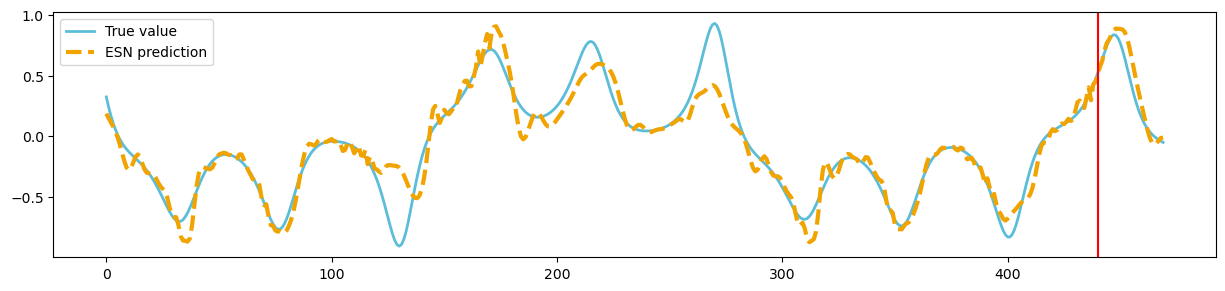

0.09077349806090687


C:\Users\nicks\AppData\Local\Temp\ipykernel_1424\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


In [15]:
#Первый тестовый набор параметров 
units = 830
leak_rate = 0.55
spectral_radius = 0.6
input_scaling = 3.
connectivity = 0.51
input_connectivity = 0.51
regularization = 1.e-08
seed = 1534



#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
print(rmse(y_pred1[-100:], X[-100:]))
###HERE1

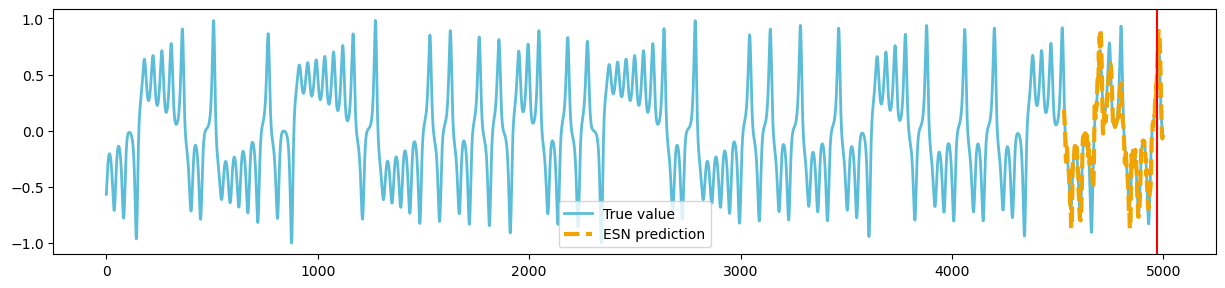

In [16]:
tmp = np.full(5000-len(y_pred1), None)
y_pred1_extended = np.concatenate([tmp.reshape(len(tmp), 1), y_pred1])
results(y_pred1_extended, X)

Running Model-585: 4500it [00:04, 965.37it/s] <?, ?it/s]
Running Model-585: 100%|██████████| 1/1 [00:04<00:00,  4.74s/it]


Fitting node Ridge-585...


Running Model-585: 470it [00:00, 1459.65it/s]           


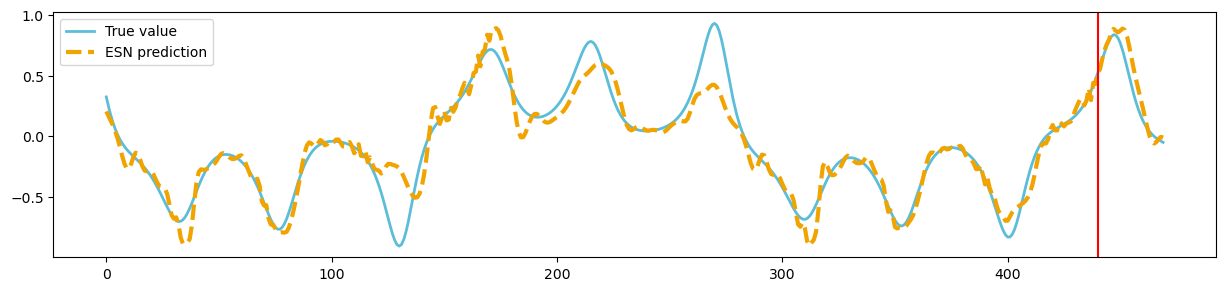

0.08999638206423798


C:\Users\nicks\AppData\Local\Temp\ipykernel_1424\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


In [23]:
#Первый тестовый набор параметров 
units = 830
leak_rate = 0.55
spectral_radius = 0.6
input_scaling = 3.
connectivity = 0.51
input_connectivity = 0.51
regularization = 1.e-08
seed = 1934

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
print(rmse(y_pred1[-100:], X[-100:]))
###HERE1